In [1]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
from matplotlib import dates

import xarray as xr
from stompy.grid import multi_ugrid
from stompy import utils, memoize, filters
import os
import six
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib notebook

In [2]:
fig_dir="fig-scenarios-20221102"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [3]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs

In [4]:
import common
six.moves.reload_module(common)
from common import (prechain, his_cache, save_as_layers, load_or_none, name_runs,
                    scen_names, slr_names, events, label_events,
                   ebb_period,flood_period,ebb_time,spring_ebb_mid,
                   spring_flood_mid, spring_ebb, spring_flood)

DFM_ROOT NOT SET
local_config: LD_LIBRARY_PATH:
/share/apps/mpfr-3.1.2/lib:/share/apps/openmpi-4.1.4/gcc7/lib:/share/apps/ucx-1.13.1/gcc7/lib:/share/apps/pmix-4.1.1/gcc7/lib:/share/apps/hwloc-2.8.0/gcc7/lib:/share/apps/libevent-2.1.12-stable/gcc7/lib:/share/apps/slurm-22.05.4/18.04/lib
------------


In [5]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

In [6]:
scen_styles={'Base':dict(color='tab:Blue'),
             'Low':dict(color='tab:Orange'),
             'Medium':dict(color='tab:Green',ls='--'),
             'High':dict(color='tab:Red')}
scen_styles['Base+SLR']=scen_styles['Base']
scen_styles['Low+SLR']=scen_styles['Low']
scen_styles['Medium+SLR']=scen_styles['Medium']
scen_styles['High+SLR']=scen_styles['High']

In [7]:
# select and label cross sections for tidal prism calculations
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             #'butano_lower_xs':'Butano Ck',
             'butano_wide':'Butano Ck',
             #'pesca_lower_xs':'Pescadero@Jct',
             #'pesca_mid_xs':'Pescadero Ck',
             'pesca_wide':'Pescadero Ck'
            }
# Just for debugging
sec_station_sel={'butano_lower_xs':'bc1',
                 'mouth_xs':'mid_mouth', # upstream side
                 'n_ditch_xs':'nmc_down', # or nmc_up?
                 'n_complex_xs':'pch_up', # upstream side of culverts
                 'n_pond_xs':'npc',
                 'pesca_mid_xs':'pch_down', # not great
                 'pesca_wide':'pch_down',
                 'butano_wide':'bc1'
                }


In [8]:
runs=run_database.select(layers=100,period='2016long',flows='impaired',
                         slr=0.0,terrain='asbuilt',load_model=True)
name_runs(runs)
runs

run_dir  scen  layers  slr  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

     period    status  terrain     flows  \
0  2016long  complete  asbuilt  impaired   
1  2016long  complete  asbuilt  impaired   
2  2016long  complete  asbuilt  impaired   
3  2016long  complete  asbuilt  impaired   

                                               model    name  
0  <DFlowModel: data_2016long_3d_asbuilt_impaired...    Base  
1  <DFlowModel: data_2016long_3d_asbuilt_impaired...     Low  
2  <DFlowModel: data_2016long_3d_asbuilt_impaired...  Medium  
3  <DFlowModel: data_2016long_3d_asbuilt_impaired...    High

Background Figures
==

Datums
--

In [10]:
import pesca_base
pbm=pesca_base.PescaButanoMixin()
qcm_ds=pbm.prep_qcm_data()

from stompy.spatial import wkb2shp, field
from stompy.grid import unstructured_grid
polys=wkb2shp.shp2geom("../grids/pesca_butano_v08/polygon_features.shp")
dem=common.dem('asbuilt')

grid=unstructured_grid.UnstructuredGrid.read_ugrid("../grids/pesca_butano_v08/grid_asbuilt_deepbathy.nc")

grid_poly=grid.boundary_polygon()

# polygons clipped to grid extent
lagoon_poly,marsh_poly,pond_poly=[
    polys['geom'][ polys['desc']==name ][0].intersection(grid_poly)
    for name in ['lagoon','marsh','pond']]

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


INFO:join_features:0 open strings, 4 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=2051183.859143, 3 potential interiors


In [ ]:
sel_open=qcm_ds.w_inlet.values>0.0

datums=pd.concat([
    pd.DataFrame({'z':qcm_ds.z_ocean.values}).assign(cat="ocean"),
    pd.DataFrame({'z':qcm_ds.z_lagoon.values[sel_open]}).assign(cat="lagoon_open_wse"),
    pd.DataFrame({'z':qcm_ds.z_lagoon.values[~sel_open]}).assign(cat="lagoon_closed_wse"),
    pd.DataFrame({'z':qcm_ds.z_ocean.values+0.61}).assign(cat="ocean_2ft"),
])


terrain=pd.concat([
    pd.DataFrame({'z':qcm_ds.z_thalweg.values}).assign(cat="thalweg"),
    pd.DataFrame({'z':dem.polygon_mask(lagoon_poly,return_values=True)}).assign(cat="lagoon"),
    pd.DataFrame({'z':dem.polygon_mask(marsh_poly,return_values=True)}).assign(cat="marsh"),
    pd.DataFrame({'z':dem.polygon_mask(pond_poly,return_values=True)}).assign(cat="pond"),   
])

labels={
    'ocean':'Ocean',
    'ocean_2ft':"Ocean+2ft",
    'lagoon_open_wse':"Lagoon WSE\n(open)",
    'lagoon_closed_wse':"Lagoon WSE\n(closed)",
    'thalweg':'Inlet\nthalweg',
    'lagoon':'Lagoon',
    'pond':'Pond',
    'marsh':'Marsh',
}
water=['ocean','ocean_2ft','lagoon_open_wse','lagoon_closed_wse']

comb=pd.concat([datums,terrain])
ngroups=len(labels)   
fig,axs=plt.subplots(1,ngroups,figsize=(8,5),sharey=True)
fig.subplots_adjust(left=0.10,right=0.90,top=0.96,bottom=0.16)

for count,cat in enumerate(labels):
    sel=comb['cat']==cat        
    ax=axs[count]
    grp=comb[sel]
    # 10-90 is pretty good.
    z_low,z_high=np.percentile(grp.z,[10,90])
    if cat in water:
        color='tab:blue'
    else:
        color='tab:brown'
    ret=ax.hist(grp.z, orientation='horizontal',bins=np.linspace(z_low,z_high,8),
                color=color)
    ax.spines['top'].set_visible(0)
    if count>0:
        ax.spines['left'].set_visible(0)
        ax.yaxis.set_visible(0)
    ax.spines['right'].set_visible(0)
    ax.set_xticks([])
    ax.set_xlabel(labels[cat],rotation=45)
    ax.grid('x')
        
        
# Grotesque grid line approach. But seaborn wouldn't do my bidding.
if 1:
    pos0=axs[0].get_position()
    posN=axs[-1].get_position()

    ax_grid=fig.add_axes([pos0.xmin,pos0.ymin,posN.xmax-pos0.xmin,pos0.height])
    ax_grid.patch.set_visible(0)
    ax_grid.xaxis.set_visible(0)
    ax_grid.spines['top'].set_visible(0)
    ax_grid.spines['left'].set_visible(0)
    ax_grid.spines['bottom'].set_visible(0)
    ax_grid.spines['right'].set_visible(0)
    ax_grid.set_yticks(axs[0].get_yticks())
    ax_grid.axis(axs[0].axis())
    ax_grid.grid('x')
    axs[0].yaxis.set_visible(0)
    ax_grid.set_ylabel('m (NAVD88)')
    twin=ax_grid.twinx()
    twin.spines['top'].set_visible(0)
    
    twin.spines['bottom'].set_visible(0)
    twin.set_ylim(1./0.3048*np.r_[ax_grid.get_ylim()])
    twin.set_ylabel('ft (NAVD88)')
fig.savefig(os.path.join(fig_dir,"datum_summary.png"),dpi=150)

Forcing Figure
--

In [11]:
met_ds=xr.open_dataset("../forcing/wind/lagoon-met.nc")

Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


<IPython.core.display.Javascript object>


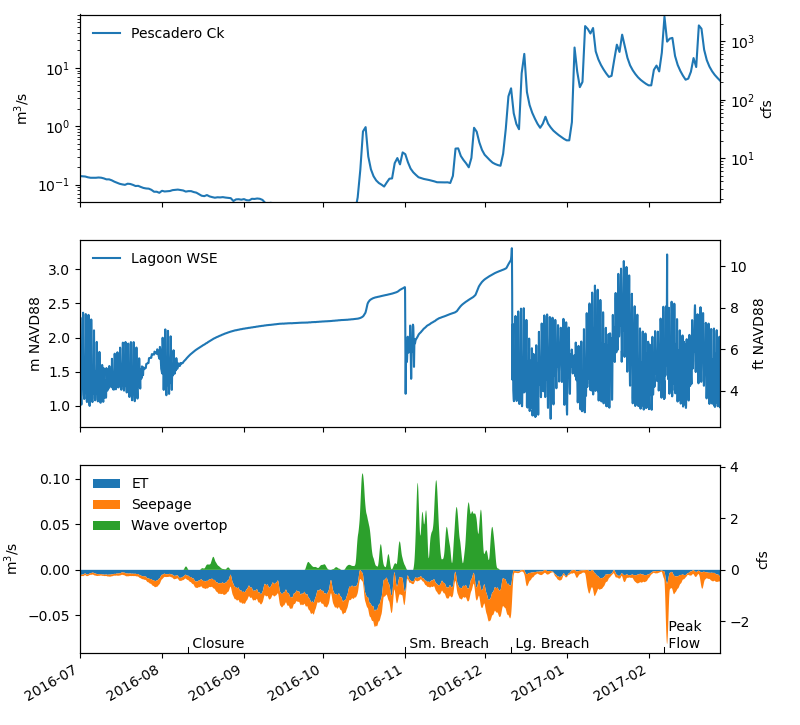

In [12]:
import local_config
six.moves.reload_module(common)
#fig=forcing_figure(['pesca_ck','lagoon_wse'])
#fig.savefig(os.path.join(fig_dir,"forcing-timeseries.png"),dpi=200)

fig=common.forcing_figure(['pesca_ck','lagoon_wse','source_sink'])
fig.savefig(os.path.join(fig_dir,"forcing-timeseries-src_sink.png"),dpi=200)


In [ ]:
df=pd.read_csv(os.path.join(local_config.model_dir,
                            "../forcing/tu_flows/TU_flows_SI.csv"),
               parse_dates=['time'])

df_pesca=df[ df.flow_desc=="Impaired flow Pe TIDAL" ]
df_pesca.flow_cms.min()


In [ ]:
# Return period for flows:
yearly_max=df_pesca.groupby(df_pesca.time.dt.year)["flow_cms"].max()
qtiles=yearly_max.quantile([0.99,0.95,0.9,0.8,0.5]).to_frame().reset_index()
qtiles['return']=1./(1-qtiles['index'])
qtiles

In [ ]:
yearly_max.iloc[-30:]

In [ ]:
Qsorted=yearly_max.to_frame().sort_values('flow_cms')
Qsorted
ranks=1+np.arange(len(Qsorted))

returns=(len(Qsorted)+1)/ranks[::-1]
Qsorted['returns']=returns
Qsorted.iloc[-15:,:]

Stage
==

Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [ ]:
def fig_waterlevel_discharge_bystation_timeseries(runs,station,label):
    fig,axs=plt.subplots(2,1,figsize=(7.5,4),sharex=True)

    # Stage at stations:
    colors={}
    ax=axs[0]
    
    for _,rec in runs.iterrows():
        #his=rec['model'].his_dataset(chain=True,prechain=prechain) # use preloaded
        wse=his_cache(rec['model'],stations=station,variable='waterlevel')
        l=ax.plot(wse.time,
                  wse,
                  label=rec['name'],
                  lw=1.5,alpha=0.6)
        colors[rec['name']]=l[0].get_color()

    if 1: # show mouth thalweg, too
        for _,rec in runs.iterrows():
            # HERE: have to add support for additional coordinates to his_cache.
            his=rec['model'].his_dataset() # use preloaded
            ax.plot(his.time,
                    his.general_structure_crest_level.sel(general_structures='mouth'),
                    label='__nolabel__',
                    ls='--',color=colors[rec['name']],
                    lw=1.5,alpha=0.6)
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')

    ax=axs[1]
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset(chain=True,prechain=prechain)
        if 'pch_gate' in his.general_structures:
            ax.plot(his.time,
                    his.general_structure_discharge.sel(general_structures='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'gategens' in his.dims and 'pch_gate' in his.gategens:
            ax.plot(his.time,
                    his.gategen_discharge.sel(gategens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'pch_gate' in his.weirgens:
            ax.plot(his.time,
                    his.weirgen_discharge.sel(weirgens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)                
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Flow (m3/s)')
    
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    fig.autofmt_xdate()
    return fig

In [ ]:
if 0: # not using these right now
    for station,label in stage_stations:
        fig=fig_waterlevel_discharge_bystation_timeseries(runs,station,label)
        fig.savefig(os.path.join(fig_dir,f'stage_Q-timeseries-2016-stn_{station}.png'),
                    dpi=150)

In [ ]:
from common import fig_waterlevel_bystation_timeseries

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(runs,station,label,min_depth=0.025,scen_styles=scen_styles)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-stn_{station}.png'),
                dpi=150)
    fig2=fig_waterlevel_bystation_timeseries(runs,station,label,as_depth=True,min_depth=0.025,
                                             scen_styles=scen_styles)
    fig2.savefig(os.path.join(fig_dir,f'depth-timeseries-2016-stn_{station}.png'),
                 dpi=150)

In [ ]:
# For ppt
station='nmp'
label='North Marsh Panne'
layers=['Base','Low','Medium','High']
fig=fig_waterlevel_bystation_timeseries(runs,station,label,min_depth=0.025,
                                        zorder=layers,scen_styles=scen_styles)
img_fn=os.path.join(fig_dir,f'stage-timeseries-2016-stn_{station}.png')
fig.savefig(img_fn.replace('.png','4.png'),dpi=150)
save_as_layers(fig,img_fn,layers,dpi=150)

In [ ]:
# one-off, thinking about high flow bed stress.
if 0:
    fig_waterlevel_bystation_timeseries(runs,'pc3','PC3',min_depth=0.025)
    fig_waterlevel_bystation_timeseries(runs,'pch_up','Culverts (N)',min_depth=0.025)
    fig_waterlevel_bystation_timeseries(runs,'pch_down','Culverts (S)',min_depth=0.025)
    None    

In [ ]:
def fig_waterlevel_timeseries(rec, as_depth=False, chain=True):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    # will use pre-loaded his dataset, so let the caller choose whether
    # to chain or not.
    
    for station,name in stage_stations:
        data = his_cache(rec['model'],stations=station,variable='waterlevel',chain=chain)
        if as_depth:
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel',chain=chain)
            data=data-z_bed        
        ax.plot(data.time,data,lw=1.2,label=name)

    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(stage_stations),
              frameon=0)
    if as_depth:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
        
    label_events(ax)
    
    ax.axis(xmin=data.time.values[0],xmax=data.time.values[-1])
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

In [ ]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec)
    img_fn=os.path.join(fig_dir,f"stage-timeseries-2016-{rec['name']}.png")
    fig.savefig(img_fn,dpi=150)
    labels=['Ocean','Lagoon','Culverts (N)','Ped. Bridge','North Marsh Panne']
    save_as_layers(fig,img_fn,labels,dpi=150)

    fig2=fig_waterlevel_timeseries(rec,as_depth=True) 
    fig2.savefig(os.path.join(fig_dir,f"depth-timeseries-2016-{rec['name']}.png"),
                 dpi=150)

Tidal Analysis
==

Tidal prism
--


In [ ]:
# Start with 2D runs
#all_runs=run_database.all_runs
tidal_runs=run_database.select(layers=100,period='2016tidal',
                               slr=0.0,terrain='asbuilt',load_model=True)
#tidal_runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016tidal')
#                    &(all_runs.slr==0.0)].copy()
name_runs(tidal_runs)
tidal_runs

In [ ]:
if 0:
    for station,label in stage_stations:
        fig_waterlevel_discharge_bystation_timeseries(tidal_runs,station,label)
        fig.savefig(os.path.join(fig_dir,f'tidal36h-stage_Q-timeseries-2016-stn{station}.png'),
                    dpi=150)

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(tidal_runs,station,label,chain=False,scen_styles=scen_styles)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-stn{station}.png'),
                dpi=150)

In [ ]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec,chain=False) 
    fig.savefig(os.path.join(fig_dir,f"tidal36h-stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)

Tidal Bed Stress
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.


In [ ]:
# Run for all tidal runs, with and w/o SLR
all_tidal_runs=run_database.select(layers=100,period='2016tidal',terrain='asbuilt',load_model=True)
name_runs(all_tidal_runs)
all_tidal_runs

In [ ]:
if 0: # shouldn't be necessary any more
    grid=None
    all_tidal_runs['model']=all_tidal_runs.run_dir.apply(load_or_none)
    for _,rec in all_tidal_runs.iterrows():
        ds=rec['model'].map_dataset(grid=grid,chain=False)
        grid=grid or ds.grid # so everybody matches the same grid

In [ ]:
# mean and max bed stress for each of the runs, for flood and ebb
class FigBedStress:
    #zoom=[552085, 552647.,4124191, 4125112]
    zoom=[552100, 553247, 4123945, 4125277] # all of N Marsh, more pond, less mouth
    figsize=(7.0,4.8)

    period_sel=None
    period=None
    cax_pos=[0.25,0.12,0.5,0.03]
    cax_label="Bed stress (Pa)"
    dz_min=0.025
    clim=[0.1,10]
    
    def __init__(self,mod,**kws):
        utils.set_keywords(self,kws)
        self.mds=mds=mod.map_dataset(chain=False)
    
        tau_max,tau_mean=self.get_bed_stress(mds)
        
        values=[tau_max,tau_mean]
        labels=['(a) Max.','(b) Mean']
        
        self.plot_panels(mdss=[self.mds,self.mds],values=values,labels=labels,
                         cmap='turbo',norm=colors.LogNorm(),)
        
    def plot_panels(self,mdss,values,labels,**kws):
        self.fig,self.axs=plt.subplots(1,2,figsize=self.figsize)
        cax=self.fig.add_axes(self.cax_pos)

        for ax,mds,vals,label in zip(self.axs,mdss,values,labels):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            valid=np.isfinite(vals)
            mds.grid.plot_cells(color='0.92',mask=~valid,lw=0.4,edgecolor='face',ax=ax)
            if self.clim:
                vals=vals.clip(self.clim[0],self.clim[1])
            ccoll=mds.grid.plot_cells(values=vals,ax=ax,
                                      lw=0.4,edgecolor='face',**kws)
            if self.clim:
                ccoll.set_clim(self.clim)

            if ax==self.axs[0]:
                cbar=plt.colorbar(ccoll,cax=cax,label=self.cax_label,
                                  pad=0.02,orientation='horizontal')
            ax.text(0.02,0.99,label,transform=ax.transAxes,va='top')
            
            ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.18,wspace=0.05,hspace=0.03)

    def get_bed_stress(self,mds):
        if self.period_sel is None and self.period is not None:
            t=mds.time.values
            period_sel=(t>=self.period[0])&(t<self.period[1])
        elif self.period is None:
            period_sel=slice(None)
        else:
            period_sel=self.period_sel
            
        tau=mds['mesh2d_taus'].isel(time=period_sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        if np.any(np.isnan(tau)):
            print("tau does have nan")
        if self.dz_min > 0.0:
            depth=mds['mesh2d_waterdepth'].isel(time=period_sel).values
            dry=np.all( depth<self.dz_min,axis=0)
            tau_max[dry]=np.nan
            tau_mean[dry]=np.nan
        return tau_max,tau_mean

# Compare mean bed stress, per tidal phase, between each scenario
# and the base
class FigBedStressChange(FigBedStress):
    map_dataset_kwargs={}
    clim=None # [-10,10]
    
    def __init__(self,model_base,model_alt,**kws):
        utils.set_keywords(self,kws)
        mds_base=model_base.map_dataset()
                
        tau_max_base,tau_mean_base =self.get_bed_stress(mds_base)
        
        mds_alt=model_alt.map_dataset(grid=mds_base.grid,**self.map_dataset_kwargs)        
        
        # Make sure the grid's are the same
        def check_match():
            cc_base=mds_base.grid.cells_center()
            cc_alt =mds_alt.grid.cells_center()
            valid_grid=np.allclose(cc_base,cc_alt)
            # with new period handling this is probably unnecessary
            valid_time=np.all(mds_base.time.values==mds_alt.time.values)
            return valid_grid and valid_time
        
        #if not check_match():
        #    print("Grids or times don't look the same. Will try reloading map_dataset")
        #    # Try reloading with forced grid:
        #    model_alt._mu=None
        #    mds_alt=model_alt.map_dataset(grid=mds_base.grid,**self.map_dataset_kwargs)
        #    assert check_match()
        
        tau_max_alt,tau_mean_alt=self.get_bed_stress(mds_alt)
        
        if not check_match():
            print("Will match grids post-hoc")
            _n,_e,cell_map = mds_base.grid.match_to_grid(mds_alt.grid)
            # cell_map gives indices into mds_alt, or -1 if no match
            print("Mapping")
            tau_max_alt =np.where(cell_map>=0, tau_max_alt[cell_map], np.nan)
            tau_mean_alt=np.where(cell_map>=0, tau_mean_alt[cell_map], np.nan)

        def d_tau(alt,base): # for difference interpret nan as 0, unless both nan
            d=np.where(np.isnan(alt),0,alt) - np.where(np.isnan(base),0,base)
            d[np.isnan(alt)&np.isnan(base)]=np.nan
            return d
        values=[d_tau(tau_max_alt,tau_max_base),
                d_tau(tau_mean_alt,tau_mean_base)]

        self.plot_panels(mdss=[mds_base,mds_base],values=values,
                         labels=[r'(a) $\Delta$ Max.',
                                 r'(b) $\Delta$ Mean'],
                         cmap='coolwarm',
                         norm=colors.SymLogNorm(0.1,vmin=-10,vmax=10,base=10)
                         #norm=colors.SymLogNorm(0.001,vmin=-1,vmax=1,base=10)
                        )


In [ ]:
# mean and max bed stress for each of the runs, for flood and ebb
# during dev, Fig code is down in breach section.
for _,rec in all_tidal_runs.iterrows():
    #if rec['name']!='Base': continue # DEV
    for period_name,period_times in [('ebb',spring_ebb),
                                     ('flood',spring_flood)]:
        fbs=FigBedStress(rec['model'],period=period_times)
        fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-{period_name}.png"),dpi=200)
    #break # DEV

In [ ]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

for _,rec in all_tidal_runs.iterrows():
    if rec['name']=='Base': continue
    
    if ( (rec['scen']==0) and (rec['slr']>0.0)) or (rec['slr']==0.0):
        rec_base=all_tidal_runs[ all_tidal_runs['name']=='Base'].iloc[0,:]
    else:
        rec_base=all_tidal_runs[ all_tidal_runs['name']=='Base+SLR'].iloc[0,:]
        
    for period,period_name in [(spring_ebb,'ebb'),
                               (spring_flood,'flood')]:
        print(period_name,rec_base['name'],rec['name'])
        fbs=FigBedStressChange(rec_base['model'],rec['model'],period=period)
        fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-{period_name}.png"),dpi=200)

In [ ]:
plt.close('all')

Tidal Prism Figures
==

NB: N Complex is flipped in the input.

In [ ]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()

In [ ]:
# Updated runs shouldn't need this.
#section_flips=['n_complex_xs'] # who needs to be inverted due to gis feature
section_flips=[]


def phase_slice(his_ds,mid_time,section):
    flow=his_ds['cross_section_discharge'].sel(cross_section=section).values
    # use just the tidally varying portion to define tidal period.
    flow_anom=flow-flow.mean()
    ti_mid=np.searchsorted(his_ds.time.values,mid_time)
    flow_mid=flow_anom[ti_mid]
    ti_start=ti_mid
    while (flow_anom[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
    ti_stop=ti_mid
    while (flow_anom[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
    return ti_start,ti_stop

def extract_volumes(his_ds,mid_time,timekeeper_section='mouth_xs'):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    durations=[]
    volumes2=[] # calculated from cumulative discharge
    volumes_tidal=[]
    t_starts=[]
    t_stops=[]
    
    if timekeeper_section:
        ti_start,ti_stop = phase_slice(his_ds,mid_time,timekeeper_section)
        
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        if section in section_flips:
            sgn=-1
        else:
            sgn=1

        if not timekeeper_section:
            ti_start,ti_stop = phase_slice(his_ds,mid_time,section)
           
        flow=sgn*his_ds['cross_section_discharge'].sel(cross_section=section).values
        flow_anom=flow-flow.mean()
        
        t=his_ds.time.values
        dt=(t[2]-t[1])/np.timedelta64(1,'s')
        # print(f"History time step {dt}s")
        volume=flow[ti_start:ti_stop].sum() * dt
        volumes.append(volume)
        
        durations.append((t[ti_stop] - t[ti_start])/np.timedelta64(3600,'s'))
        Qnet=sgn*his_ds['cross_section_cumulative_discharge'].isel(cross_section=i).values
        volumes2.append(Qnet[ti_stop] - Qnet[ti_start])
        volumes_tidal.append( (flow_anom[ti_start:ti_stop]).sum()*dt)
        t_starts.append( t[ti_start])
        t_stops.append(t[ti_stop])

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    prism_ds['vol_Qnet']=('cross_section',),volumes2
    prism_ds['vol_tidal']=('cross_section',),volumes_tidal
    prism_ds['duration_h']=('cross_section',),durations 
    prism_ds['t_start']=('cross_section',),t_starts
    prism_ds['t_stop'] =('cross_section',),t_stops
    return prism_ds

In [ ]:
# Prism table:
prisms=[]
for tk in [None,'mouth_xs']:
    for _,row in tidal_runs.iterrows():
        ds=extract_volumes(row['model'].his_dataset(),ebb_time,timekeeper_section=tk)
        ds['run']=(),row['name']
        ds['timebase']=(),(tk or 'local')
        del ds['cross_section_name']
        del ds['vol_Qnet'] # was for debugging -- matches well.
        prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 200)
prisms

In [ ]:

for tbase in prisms['timebase'].unique():
    print("Time base",tbase)
    df=prisms[ prisms['timebase']==tbase]
    df=df['volume'].unstack().reset_index()
    df=df[ df.cross_section.isin(section_sel)].copy()

    df['Cross section']=df['cross_section'].map(section_sel)

    df=df.set_index('Cross section')
    del df['cross_section']
    df.to_csv(os.path.join(fig_dir,f"ebb-prisms-timebase_{tbase}.csv"))

    # Just for display:
    for col in df.columns:
        df[col]=df[col].apply(lambda s: "%.0f"%s)
    display(df)

When ebb prisms are calculated with the period of ebb decided locally
then we can't turn around and attempt a mass balance across sections.

When all sections are evaluated with the same time base, from a designated
"timekeeper" section, the mass balance is appropriate.

The second table shows that in the scenarios Butano ebbs 8k more, Pescadero
ebbs 5500 more, and the North Marsh contribution is cut from 32k to zero. Net,
there is 18,500 m$^3$ less flow entering the lagoon. There is also 12k less flow
out of the lagoon. The difference, 6k, is because the tidal range increases
in the scenarios.

In [ ]:
plt.close('all')

Tidal Cross Section Map
--

In [ ]:
from stompy.plot import plot_wkb
mds=tidal_runs.model.values[0].map_dataset()
# there was a hopefully transient issue with cross sections in run 0,
# so pull from run 1
his=tidal_runs.model.values[1].his_dataset()

In [ ]:
from stompy import filters

fig,ax=plt.subplots(figsize=(8,9))
ax.set_adjustable("datalim")
tidx=20 # start of ebb period
#depth=mds['mesh2d_waterdepth'].isel(time=tidx)
elev=mds['mesh2d_flowelem_bl']
ccoll=mds.grid.plot_cells(values=elev,ax=ax,cmap='terrain')

colors=['k','r','b','orange','magenta','green','brown','purple']
    
for sec in his.cross_section:
    sec=sec.item()
    if sec not in section_sel: continue
    geom=his.cross_section_geom.sel(cross_section=sec).values.item()
    coords=np.array(geom.coords)
    coords[1:-1] = filters.lowpass_fir(coords,3,axis=0)[1:-1]
    color=colors.pop(0)
    #plot_wkb.plot_wkb(geom,color=color,lw=2)
    ax.plot(coords[:,0],coords[:,1],color=color,lw=2)
    mid=np.array(geom.interpolate(0.5,normalized=True).coords)[0]
    ax.text(mid[0],mid[1],' ' +section_sel[sec] )
ccoll.set_clim(0,5.)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.tight_layout()
ax.axis((552046., 552657., 4124176., 4124890.))
fig.savefig(os.path.join(fig_dir,'cross_section_map.png'),dpi=200)

In [ ]:
plt.close('all')

Freshening
==

Time to freshen
--

Time for depth-averaged salinity to reach 5ppt, after closure.

In [ ]:
fresh_runs=runs

In [ ]:
t_close=np.datetime64("2016-08-11 00:00")

In [ ]:
if 0:
    # When did it close?  Hopefully all of the runs will use the same starting
    # time, so we can reuse the closure timing
    # 8-09 might be closer?
    his_ds=fresh_runs.model.values[0].his_dataset()
    nck=his_ds.waterlevel.sel(stations='nck')
    fig,ax=plt.subplots()
    ax.plot(nck.time, nck)
    ax.axvline(t_close,color='tab:red')
    fig.autofmt_xdate()

In [ ]:
print("Days after closure of mini-breach",(np.datetime64('2016-11-01') - t_close)/np.timedelta64(1,'D'))
print("Days after closure of large breach",(np.datetime64('2016-12-11') - t_close)/np.timedelta64(1,'D'))

In [ ]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def scal_davg(mds,ti,scal,dz_min=0.0):
    snap=mds.isel(time=ti)
    values=snap[scal].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    davg=np.nansum(weights*values,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    if dz_min==0.0:
        dry=dry | (snap.mesh2d_waterdepth<dz_min)
    davg[dry]=np.nan
    return davg

def s_davg(mds,ti):
    return scal_davg(mds,ti,'mesh2d_sa1')

def calc_days_to_freshen(mod,t_close,s_thresh=5.0):
    mds=mod.map_dataset(chain=True)
    # Extra layer to roughly cache results, but update if new output is available.
    # Assumes we're going to load the map_dataset() regardless.
    return real_calc_days_to_freshen(mod,t_close,s_thresh,mds.time.values[-1])

@memoize.memoize(cache_dir='cache',key_method='str') # untested.
def real_calc_days_to_freshen(mod,t_close,s_thresh,t_end):    
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t_close)
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    # HERE - need chaining logic.
    for ti in range(ti_close,mds.dims['time']):
        #print(f"{ti}/{mds.dims['time']}", end='  ')    
        print(".",end="")
        salt_i=s_davg(mds,ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [ ]:
# Survey initial, depth-averaged salinity field
def figure_salinity(mod,t=t_close,label=None):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t)
    if t < mds.time.values[0]:
        # HERE -- add some restart chaining logic
        logging.warning("Output starts after the requested time")
    salt0=s_davg(mds,ti_close)

    fig,ax=plt.subplots(figsize=(7.2,4.75))
    ax.set_adjustable('datalim')
    ccoll=mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])
    bgcoll=mds.grid.plot_cells(mask=np.isnan(salt0),color='0.85',zorder=-2,lw=0.5,edgecolor='face')

    ax.axis('off')
    #zoom=[551953., 553097.,4124145., 4125066.]
    zoom=[551951., 553291., 4124136., 4125020.]
    ax.axis(zoom)
    cax=fig.add_axes([0.55,0.9,0.40,0.03])
    cbar=plt.colorbar(ccoll,cax=cax,orientation='horizontal',label='psu')
    fig.subplots_adjust(left=0.0,right=1.0,top=1.0,bottom=0.0)
    if label:
        ax.text(0.02,0.9,label,transform=ax.transAxes)
    return fig

In [ ]:
t_initial=np.datetime64('2016-07-01 00:00') # correct for period=2016long 

for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset(chain=True)
    fig=figure_salinity(run['model'],t=t_initial,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-initial-{run["name"]}.png'),
               dpi=200)

In [ ]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset()
    t_stop=mapds.time.values[-1]
    t_stop_label=utils.to_datetime(t_stop).strftime('%Y-%m-%d')
    fig=figure_salinity(run['model'],t=t_stop,label=f"{run['name']} {t_stop_label}")
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-final-{run["name"]}.png'),
               dpi=200)                

In [ ]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    fig=figure_salinity(run['model'],t=t_close,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-at_closure-{run["name"]}.png'),
               dpi=200)
    

In [ ]:
def fig_freshen(rec,t_close=t_close,max_days=160):
    mod=rec['model']
    mds=mod.map_dataset(chain=True)
    duration_days=(mds.time.values[-1]-t_close)/np.timedelta64(1,'D')
    print(f"Days to freshen from closure {t_close} to end of run {mds.time.values[-1]} ({duration_days:.1f}d)")

    t_fresh=calc_days_to_freshen(mod,t_close)
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    valid=np.isfinite(t_fresh)
    mds.grid.plot_cells(color='0.65',zorder=-1,mask=~valid,lw=0.4,edgecolor='face')
    ccoll=mds.grid.plot_cells(values=t_fresh,mask=valid,cmap='turbo',zorder=1,
                              lw=0.4,edgecolor='face')
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
    cax=fig.add_axes([0.05,0.08,0.03,0.45])
    cbar=plt.colorbar(ccoll,cax=cax)# ,label="days")
    ccoll.set_clim([0,max_days])

    if 1: # label by events instead of days.
        ticks=[]
        ticklabels=[]
        for t,label in events:
            days=(t-t_close)/np.timedelta64(24,'h')
            ticks.append(days)
            ticklabels.append(label.strip())
        #ticks.append(max_days)
        #ticklabels.append( utils.to_datetime(t_close+np.timedelta64(max_days,'D')).strftime('%Y-%m-%d') )
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticklabels)

    #zoom=[551894., 553097.,4124145., 4125066.]
    zoom=[551951., 553291., 4124136., 4125020.]
    ax.axis(zoom)
    return fig

In [ ]:
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    fig=fig_freshen(rec,max_days=200)
    fig.savefig(os.path.join(fig_dir,f"t_fresh-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

In [ ]:
plt.close('all')

Habitat and salinity
--

In [ ]:
# Habitat: time series of area in NM that is wet and <5, <10 ppt depth-max salinity
from common import (fresh_wet_area, fig_habitat, 
                    fig_habitat_by_region, fig_habitat_by_region_relative)

In [ ]:
# Get the polygons for marsh and pond
region_names=['marsh','pond','lagoon']

for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    fig=fig_habitat(result)
    fig.savefig(os.path.join(fig_dir,f"habitat-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

In [ ]:
# Get the polygons for marsh and pond
region_names=['marsh','pond','lagoon']

results=[]
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    if 'thresholds' in result:
        result['threshold']=result['thresholds']
    result['name']=(),rec['name']
    results.append(result)

full_results=xr.concat(results,dim='name')

# group by region
for region in region_names:
    per_region=full_results.sel(region=region) 
    fig=fig_habitat_by_region(per_region)
    img_fn=os.path.join(fig_dir,f"habitat-region_{region}-{rec['flows']}-{rec['period']}.png")
    fig.savefig(img_fn, dpi=200)

In [ ]:
# Get the polygons for marsh and pond
region_names=['marsh','pond','lagoon']

results=[]
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    if 'thresholds' in result:
        result['threshold']=result['thresholds']
    result['name']=(),rec['name']
    results.append(result)

full_results=xr.concat(results,dim='name')

# group by region
for region in region_names:
    per_region=full_results.sel(region=region) 
    fig=fig_habitat_by_region_relative(per_region,scen_styles=scen_styles)
    img_fn=os.path.join(fig_dir,f"habitat_relative-region_{region}-{rec['flows']}-{rec['period']}.png")
    fig.savefig(img_fn, dpi=200)

In [ ]:
plt.close('all')

Breach
==

Tracer and Exposure
--

In [ ]:
breachruns=run_database.select(layers=100,slr=0.0,period='2016breach',terrain='asbuilt',
                               load_model=True)
name_runs(breachruns)
breachruns

In [ ]:
breachruns['model']=breachruns.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [ ]:
# Choose a few key moments in time for snapshots
# these runs go from 2016-12-08 to 2016-12-16
def fig_tracer_snapshots(mod,tracer='marsh',
                            times=[np.datetime64("2016-12-09"),
                                   np.datetime64("2016-12-12"),
                                   np.datetime64("2016-12-14")]):
    his=mod.his_dataset()
    mds=mod.map_dataset()

    fig,axs=plt.subplots(1,len(times),figsize=[8.3,3.4])
    fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.03)

    # one time series 
    ax_t=fig.add_axes([0.03,0.06,0.3,0.14])
    ax_t.plot( his.time, his.waterlevel.sel(stations='nck'))
    ax_t.axis(xmin=his.time.values[0],xmax=his.time.values[-1])
    ax_t.xaxis.set_visible(0)
    ax_t.yaxis.set_visible(0)
    zoom=[551951., 553291., 4124136., 4125020.]

    for t,ax,label in zip(times,axs,"abcdefgh"):
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)

        tidx=np.searchsorted(mds.time.values,t)
        ax_t.axvline(mds.time.values[tidx],color='0.5',lw=1.5)

        scal=scal_davg(mds,tidx,'mesh2d_'+tracer)
        if 1:
            depth=mds['mesh2d_waterdepth'].isel(time=tidx).values
            valid=depth>0.025 
            mds.grid.plot_cells(color='0.8',lw=0.4,edgecolor='face',ax=ax,mask=~valid)
        ccoll=mds.grid.plot_cells(values=scal,cmap='turbo',lw=0.4,edgecolor='face',
                                  ax=ax,mask=valid)
        ccoll.set_clim([0,1])
        ax.axis(zoom)
        ax.text(0.02,0.98,f"({label})",va='top',transform=ax.transAxes)
        ax.axis('off')

    p0=axs[0].get_position()
    p1=axs[1].get_position()
    cax=fig.add_axes([p0.xmax-0.4*p0.width,0.82,p0.width*0.6,0.04])
    plt.colorbar(ccoll,cax=cax,label=f"{tracer} dye tracer",orientation='horizontal')
    return fig

In [ ]:
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        fig=fig_tracer_snapshots(rec['model'],tracer=tracer)
        fig.savefig(os.path.join(fig_dir,f"breach-snapshots-{tracer}-2016-{rec['name']}.png"),
                    dpi=200)

In [ ]:
def tracer_exposure(mod,tracer):
    mds=mod.map_dataset(chain=False)
    t_end=mds.time.values[-1]
    return real_tracer_exposure(mod,tracer,t_end,dz_min=0.025)

@memoize.memoize(cache_dir='cache',key_method='str')
def real_tracer_exposure(mod,tracer,t_end,dz_min=0.0):
    mds=mod.map_dataset(chain=False)
    exposure=np.zeros(mds.grid.Ncells(),np.float64)
    dt=(mds.time.values[1]-mds.time.values[0])/np.timedelta64(1,'s')

    for tidx,t in enumerate(utils.progress(mds.time.values)):
        print(mds.time.values[tidx])
        scal=scal_davg(mds,tidx,'mesh2d_'+tracer,dz_min=dz_min)
        scal[np.isnan(scal)]=0.0
        exposure+=scal*dt
    return exposure


In [ ]:
# Might have to rerun scen0 -- the marsh release region dips over the
# levee and contaminates the results esp. for exposure.
# Is this issue gone in the scen1 output?
# hmm - worse than that. I think the levee might actually be leaky?
# The DEM goes down to 2.65m here.
from matplotlib import colors

def fig_exposure(mod,tracer):
    exposure=tracer_exposure(mod,tracer)
    mds=mod.map_dataset(chain=False)
    
    fig,ax=plt.subplots()
    ax.axis('off')
    ax.set_adjustable('datalim')
    scal=exposure/3600. # hours.
    
    ccoll=mds.grid.plot_cells(values=scal.clip(0.1,8*24),
                              norm=colors.LogNorm(vmin=1,vmax=8*24,clip=True),
                              cmap='turbo',lw=0.5,edgecolor='face',
                              ax=ax)
    plt.colorbar(ccoll,label='Exposure (h)')
    zoom=[551951., 553291., 4124136., 4125020.]
    fig.subplots_adjust(left=0.01,right=0.99,top=0.97,bottom=0.03)
    ax.axis(zoom)
    return fig

In [ ]:
# Integrate exposure to marsh water
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        mod=rec['model']
        fig=fig_exposure(mod,tracer)
        img_fn=os.path.join(fig_dir,f"breach-exposure-{tracer}-2016-{rec['name']}.png")
        print("Saving to ",img_fn)
        fig.savefig(img_fn,
                    dpi=200)

In [ ]:
plt.close('all')

Bed stress during breach
--

In [ ]:
breach_period=[np.datetime64("2016-12-08"),
               np.datetime64("2016-12-16")]

for _,rec in breachruns.iterrows():
    fbs=FigBedStress(rec['model'],period=breach_period)
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-breach.png"),dpi=200)

In [ ]:
rec_base=breachruns[ breachruns['name']=='Base'].iloc[0,:]

for _,rec in breachruns.iterrows():
    if rec['name']=='Base': continue
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-breach.png")
    #if os.path.exists(img_fn): continue
                        
    fbs=FigBedStressChange(rec_base['model'],rec['model'],period=breach_period)
    fbs.fig.savefig(img_fn,dpi=200)

In [ ]:
plt.close('all')

High Flow Bed Stress
==

In [ ]:
runs=run_database.select(layers=100,period='2016long',flows='impaired',slr=0.0,
                        terrain='asbuilt',load_model=True)
name_runs(runs)
runs

In [ ]:
period_dates=[np.datetime64('2017-01-04'), np.datetime64('2017-02-27') ]

for _,rec in runs.iterrows():
    fbs=FigBedStress(rec['model'],period=period_dates)
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-highflow.png"),dpi=200)


In [ ]:
rec_base=runs[runs['name']=='Base'].iloc[0,:]
#kws=dict(zoom=(551904., 553317., 4123944., 4125157.),
#         figsize=(9.1,5))

for _,rec in runs.iterrows():
    if rec['name']=='Base': continue
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-highflow.png")
    #print(f"Checking for image {img_fn}")
    #if os.path.exists(img_fn): continue
    fbs=FigBedStressChange(rec_base['model'],rec['model'],period=period_dates)
    fbs.fig.savefig(img_fn,dpi=200)


Salinity time series
==

In [ ]:
salt_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

from stompy import filters
from common import fig_salinity_bystation_timeseries, twin_stage


In [ ]:
for station,label in salt_stations:
    if station!='nck':
        continue # DBG
    fig=fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-2016-stn_{station}.png'),
                dpi=150)    
    twin_stage(fig,runs)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-2016-stn_{station}-with_stage.png'),
                dpi=150)

In [ ]:
def fig_salinity_bystation_z_timeseries(runs,station,as_delta=False):
    fig,axs=plt.subplots(len(runs),1,sharex=True,
                         figsize=(7.5,10))
    
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14,hspace=0.01)
    
    t_starts=[]
    t_stops =[]
    
    for ax,(_,rec) in zip(axs,runs.iterrows()):
        salt=his_cache(rec['model'],stations=station,variable='salinity') 
        kws=dict(cmap='turbo')
        
        if as_delta:
            if ax==axs[0]:
                salt_ref=salt
            else:
                salt=salt-salt_ref
                kws=dict(cmap='coolwarm',
                         clim=[-7,7])
                
        img=ax.imshow(salt.values.T,
                      extent=[dates.date2num(salt.time[0]),
                              dates.date2num(salt.time[-1]),
                              0,1],
                      origin='lower',aspect='auto',
                      **kws)
        t_starts.append(salt.time.values[0])
        t_stops.append(salt.time.values[-1])
        ax.text(0.01,0.99,rec['name'],transform=ax.transAxes,va='top')
        plt.colorbar(img,ax=ax)
        label_events(ax,ticklabels=ax==axs[-1])
            
    fig.autofmt_xdate()
    return fig
    
#for station,label in salt_stations:
#    if station!='nck':
#        continue # DBG
#station='nck'
station='thalweg_pesc_0010' # between mouth_xs and source/sink location
#station='thalweg_pesc_0011' # source/sink location - not clear this is any different.

fig=fig_salinity_bystation_z_timeseries(runs.iloc[1:,:],station,as_delta=True)

Medium? WTF?
==

First, what is going on with Medium around 2016-08-26?

1. problem with chaining? nope. _r00 starts 7/14, runs until 1/07.
2. balance issue? unlikely. It's pretty solid until a blip mid-Dec, and some bad
   news in Jan.
3. difference in 
    MDU: nope
    DFM: appears to be the same compile
    grid: geometry matches
    bathy: there are 3 scatter nodes with shallower bathy.
    seepage: differences below 5e-5
4. Timing is maybe consistent with some wave overtopping. 
5. Check all pli and pliz files
   - all identical except marsh_levee_east, as expected.
6. Check salt flux near mouth, and at mouth structure.
7. Source/sink?
   - seepage: appears that Medium spits out about 50m3 less water over Sept and Oct? Doesn't seem
     relevant.
   - wave_overtop: identical (to 1e-9)
8. Balances:
   - difference in reported salt storage is O(2000kg). not sure I'm calculating that correctly.
   - At a constrast in the lagoon of maybe 5ppt, 2000kg, this error could affect roughly 400 m3. I think it's too  small.
   - integrating the salinity field from map output, scen2 has 50000 kg less salt. And it looks like a lot of that is right at the mouth structures, with some showing up landward of there. This is driven by the salinity field. scen2 has slightly more water mass (~300 m3 across the whole domain, and little of that is near the mouth).
   - really seems like the row of cells between the two mouth structures is where the shit hits the fan.and
     then it is somehow advecting into the domain? Velocities are all over the place, and I don't have much velocity data.
     
Last thing is to take a closer look at the balance files, conside the other terms, and see if I'm
using storage correctly.
May have to wait for the new runs to get into September, see if that sheds any light.


In [ ]:
if 1:
    chain=runs.iloc[2,:]['model'].chain_restarts()

    mod1=dfm.DFlowModel.load("data_2016long_3d_asbuilt_impaired_scen1_l100-v004")
    mod2=dfm.DFlowModel.load("data_2016long_3d_asbuilt_impaired_scen2_l100-v007_r00")

    # geometry matches
    grid1=mod1.grid
    grid2=mod2.grid

    print( np.all(grid1.cells['nodes']==grid2.cells['nodes']) )
    print( np.all(grid1.edges['nodes']==grid2.edges['nodes']) )
    print( np.all(grid1.nodes['x']==grid2.nodes['x']) )

In [ ]:
if 0:
    fig,ax=plt.subplots(1,1)
    grid1.contourf_node_values( grid2.nodes['depth'],
                                np.linspace(0.0,4.5,50),cmap='gray',
                                ax=ax,extend='both')
    grid1.contourf_node_values( grid2.nodes['depth'] - grid1.nodes['depth'],
                               np.linspace(-0.05,-0.001,5),cmap='coolwarm',
                               ax=ax)
    #for ax in axs:
    ax.axis('equal')
    ax.axis('off')

In [ ]:
#src='seepage.tim'
src='wave_overtop.tim'

# seepage or wave overtopping flux weirdness?
seep1=pd.read_csv(os.path.join(mod1.run_dir,src),names=['minutes','flow','extra_salt'],sep='\s+')
seep2=pd.read_csv(os.path.join(mod2.run_dir,src),names=['minutes','flow','extra_salt'],sep='\s+')
fig,(ax,ax_delta)=plt.subplots(2,1,sharex=True)
ax.plot(seep1.minutes,seep1.flow,label='model1')
ax.plot(seep2.minutes,seep2.flow,label='model2',ls='--')

seep2_at_1=np.interp(seep1.minutes, seep2.minutes,seep2.flow)
delta=seep2_at_1 - seep1.flow
ax_delta.plot(seep1.minutes,delta)

In [ ]:
from stompy.grid import unstructured_grid
#mod1._mu=None
mod2._mu=None
mds1=mod1.map_dataset(chain=False)
mds2=mod2.map_dataset(chain=False,grid=mds1.grid)

In [ ]:
t=np.datetime64("2016-09-01 00:00")
#   most shallows of lagoon, at the mouth structure, and extending up Butano,
#   scen2 is fresher
# back a few days, signal is smaller. maybe from the mouth structure?

#t=np.datetime64("2016-08-12 00:00")

zoom=(551972.5512342796, 552591.4749521209, 4124150.394976478, 4124911.6000087657)

fig,axs=plt.subplots(1,3,figsize=(9,6))
mdss=[mds1,mds2]


salts=[ mds['mesh2d_sa1'].isel(time=np.searchsorted(mds.time.values,t))
       for mds in mdss]
for ax in axs:
    ax.set_adjustable('datalim')
    
for ax,mds,scal in zip(axs[:2],[mds1,mds2],salts):
    scal=np.nanmean(scal,axis=1)
    ccoll=mds.grid.plot_cells(values=scal,ax=ax,cmap='turbo')
    ccoll.set_clim(0,33)
    ax.axis('off')
    ax.axis(zoom)

ax=axs[2]
scal=np.nanmax(salts[1],axis=1) - np.nanmax(salts[0],axis=1)
# Try to get back to a difference in salt mass?
#vols=[ mds['mesh2d_vol1'].isel(time=np.searchsorted(mds.time.values,t))
#       for mds in mdss]
#mass1=np.nansum(salts[0].values*vols[0].values,axis=1)
#mass2=np.nansum(salts[1].values*vols[1].values,axis=1)
#mass1=np.nansum(vols[0].values,axis=1)
#mass2=np.nansum(vols[1].values,axis=1)
#scal=mass2-mass1
ccoll=mds.grid.plot_cells(values=scal,ax=ax,cmap='coolwarm')

scale=10 # np.abs(scal).max()
ccoll.set_clim(-scale,scale)
ax.axis('off')
ax.axis(zoom)
    
if 1: # quiver from his data
    for ax,his in zip(axs,[mod1.his_dataset(),mod2.his_dataset()]):
        snap=his.sel(time=t,method='nearest')
        u=np.nanmean(snap.x_velocity.values,axis=1)
        v=np.nanmean(snap.y_velocity.values,axis=1)
        x=snap1['station_x_coordinate'].values
        y=snap1['station_y_coordinate'].values
        ax.quiver(x,y,u,v,zorder=10)

fig.tight_layout()

In [ ]:
import glob
import stompy.model.delft.io as dio

mod1_plis=glob.glob(os.path.join(mod1.run_dir,'*.pli*'))
mod2_plis=glob.glob(os.path.join(mod2.run_dir,'*.pli*'))
mod1_plis.sort()
mod2_plis.sort()

#print("PLI filenames match: ",np.all(np.r_[mod1_plis] == np.r_[mod2_plis]))

for fn1,fn2 in zip(mod1_plis,mod2_plis):
    pli1=dio.read_pli(fn1)
    pli2=dio.read_pli(fn2)
    assert os.path.basename(fn1)==os.path.basename(fn2)
    assert fn1!=fn2
    
    for (feat1, xy1,_),(feat2,xy2,_) in zip(pli1,pli2):
        assert feat1==feat2
        
        if not np.allclose(xy1,xy2):
            print(f"{os.path.basename(fn1)}: {feat1} not exact match on xyz")
            #raise Exception()
        else:
            #print(f"{os.path.basename(fn1)}: {feat1} ✓")
            pass
        

In [ ]:
his1=mod1.his_dataset(chain=True,prechain=prechain)
his2=mod2.his_dataset(chain=True,prechain=prechain)

In [ ]:
#stn='thalweg_pesc_0010' # just upstream of mouth_xs
stn='thalweg_pesc_0011' # source/sink location

(his1.station_x_coordinate.sel(stations=stn).item(),
 his1.station_y_coordinate.sel(stations=stn).item())


In [ ]:
# Salt flux 
#vname='cross_section_cumulative_salt' # or cumulative salt
#sel=dict(cross_section='mouth_xs')

#vname='source_sink_prescribed_salinity_increment'
#sel=dict(source_sink='seepage')

vname='water_balance_volume_error'
sel={}

fig,(ax,axd)=plt.subplots(2,1,sharex=True)

v1=his1[vname].sel(sel)
v2=his2[vname].sel(sel)

# with chaining cumulative doesn't line up. fudge it.
offset= ( v1.sel(time=np.datetime64("2016-07-11 11:00")).values 
         - v2.sel(time=np.datetime64("2016-07-11 11:00")).values)
offset
delta=v2-v1

ax.plot(his1.time, v1, label='scen1')
ax.plot(his2.time, v2 + offset,label='scen2',ls='--')
axd.plot(delta.time, delta+offset)


In [ ]:
fig.autofmt_xdate()

In [ ]:
# Read mass balances:
def readbal(mod):
    csv_fn=os.path.join(mod.run_dir,'DFM_OUTPUT_flowfm','flowfm_0000_mass_balances.csv')
    df=pd.read_csv(csv_fn,parse_dates=['datetimestart','datetimestop'])
    df.columns = [s.strip() for s in df.columns]
    print(df.columns)
    df=df[ df['Mass Balance Area']=='Unnamed' ]
    df=df[ df['Constituent']=='salt' ] # "Water"
    del df['Mass Balance Area']
    del df['Constituent']
    del df['datetimestop']
    del df['Balance Term Type']
    df['Balance Term Name']=df['Balance Term Name'].map(lambda s: s.strip())
    # Both ends of seepage, wave_overtop are reported.
    df=df.groupby(['datetimestart','Balance Term Name']).sum()

    #df=df.set_index(['datetimestart','Balance Term Name'])
    # Additionally just report Nett?
    del df['In']
    del df['Out']
    df=df.unstack(1).droplevel(0,axis=1)
    return df
bal1=readbal(mod1)
bal2=readbal(mod2)

In [ ]:
combined.head()

In [ ]:
fig,(ax,axd)=plt.subplots(2,1,sharex=True)
ax.plot( bal1.index.values, bal1.Storage,label='scen 1')
ax.plot( bal2.index.values, bal2.Storage,label='scen 2')
combined=bal1.join(bal2,rsuffix='2')

axd.plot(combined.index.values, combined['Storage2'] - combined['Storage'] )

In [ ]:
# ideas for other history output to look at:
# source_sink_cumulative_volume
# source_sink_prescribed_salinity_increment (should be all 0)
# load mass balance data, see if any terms are different.
v=list(his1)
v.sort()
v

In [ ]:
plt.close('all')

Sea Level Rise
==

Inlet Bathymetry
--

Show how the inlet depth is adjusted

In [ ]:
base_slr_runs=run_database.select(scen=0,period='2016long',flows='impaired',layers=100,
                                 terrain='asbuilt',load_model=True)
model_slr =base_slr_runs[ base_slr_runs.slr==0.61]['model'].values[0]
model_base=base_slr_runs[ base_slr_runs.slr==0.00]['model'].values[0]
base_slr_runs

In [ ]:
#model_slr=dfm.DFlowModel.load(run_slr)
#model_base=dfm.DFlowModel.load(run_base)

In [ ]:
# This will fail if the grids are ever out of sync
mds_slr=model_slr.map_dataset()
mds_base=model_base.map_dataset(grid=mds_slr.grid)

In [ ]:
# Figure showing how the mouth if adjusted.

zoom_mouth=[551963., 552311., 4124425., 4124912.]
fig,axs=plt.subplots(1,3,figsize=[8.5,3.5])

plt.setp(axs,adjustable='datalim')

z_base=mds_base['mesh2d_flowelem_bl'].values
z_slr = mds_slr['mesh2d_flowelem_bl'].values
delta=z_slr-z_base

coll0=mds_base.grid.plot_cells(values=z_base,ax=axs[0],cmap='turbo')
coll1=mds_slr.grid.plot_cells(values=z_slr,ax=axs[1],cmap='turbo')
coll2=mds_slr.grid.plot_cells(values=delta,cmap='coolwarm',clim=[-0.75,0.75])

for coll in [coll0,coll1]:
    coll.set_clim([0,3.5])
    
for ax in axs:
    ax.axis(zoom_mouth)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02)

cax0=fig.add_axes([0.23,0.52,0.02,0.40])
cax2=fig.add_axes([0.885,0.52,0.02,0.40])
plt.colorbar(coll0,cax=cax0,label='m')
plt.colorbar(coll2,cax=cax2,label='m')

for label,ax in zip('abc',axs):
    ax.text(0.05,0.98,f"({label})",transform=ax.transAxes,va='top')
fig.savefig(os.path.join(fig_dir,'slr_mouth_adjustment.png'),dpi=200)

SLR Salinity
--

In [ ]:
base_slr_runs=base_slr_runs.copy()

base_slr_runs['name']=base_slr_runs.slr.map({0.00:'Base',0.61:'Base+SLR'})
base_slr_runs['model']=base_slr_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
base_slr_runs

In [ ]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(base_slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-base_slr-2016-stn_{station}.png'),
                dpi=150)
    

In [ ]:
slr_runs=run_database.select(layers=100,slr=0.61,period='2016long',
                             flows='impaired',terrain='asbuilt',load_model=True)
name_runs(slr_runs)
slr_runs

In [ ]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-slr-2016-stn_{station}.png'),
                dpi=150)
    twin_stage(fig,slr_runs)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-slr-2016-stn_{station}-with_stage.png'),
                dpi=150)


In [ ]:
plt.close('all')

In [ ]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(slr_runs,station,label,min_depth=0.025,scen_styles=scen_styles)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-slr-2016-stn_{station}.png'),
                dpi=150)
    fig2=fig_waterlevel_bystation_timeseries(slr_runs,station,label,as_depth=True,
                                             min_depth=0.025,scen_styles=scen_styles)
    fig2.savefig(os.path.join(fig_dir,f'depth-timeseries-slr-2016-stn_{station}.png'),
                 dpi=150)
    

In [ ]:
for _,rec in slr_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"stage-timeseries-slr-2016-{rec['name']}.png"),
                dpi=150)
    fig2=fig_waterlevel_timeseries(rec,as_depth=True) 
    fig2.savefig(os.path.join(fig_dir,f"depth-timeseries-slr-2016-{rec['name']}.png"),
                 dpi=150)

In [ ]:
# Get the polygons for marsh and pond
region_names=['marsh','pond','lagoon']

results=[]
for _,rec in slr_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    if 'thresholds' in result:
        result['threshold']=result['thresholds']
    result['name']=(),rec['name']
    results.append(result)

full_results=xr.concat(results,dim='name')

# group by region
for region in region_names:
    per_region=full_results.sel(region=region) 
    fig=fig_habitat_by_region_relative(per_region,scen_styles=scen_styles)
    img_fn=os.path.join(fig_dir,f"habitat_relative-region_{region}-{rec['flows']}-{rec['period']}-slr.png")
    fig.savefig(img_fn, dpi=200)

SLR Tidal Prism
--

In [ ]:
all2016tidal=run_database.select(layers=100,period='2016tidal',
                                flows='impaired',terrain='asbuilt',
                                load_model=True)
name_runs(all2016tidal)

if 1: # also show existing conditions
    existing=run_database.select(layers=100,period='2016long',flows='impaired',
                                terrain='existing',load_model=1)
    existing['name']='pre-Base'
    all2016tidal=pd.concat([all2016tidal,existing])
all2016tidal

In [ ]:
# Those collapse to 4 lines. Positive slope should be seaward=ebb.
# Verified that SLR runs around "ebb_time" do not cleanly reverse.
# 2016-08-02 10:00 looks decent for a large ebb.
# 2016-08-02 04:00 okay for large flood
# This is squarely a spring tide, and the larger spring tide.

In [ ]:
def extract_prism_from_netQ(netQ,mid_time,slope=1):
    """ more streamlined and cache-friendly version of extract_volumes.
    Accepts just the cumulative discharge data array. Use DFM's
    integration. flow must be pre-flipped as needed
    
    slope: +1 gives ebb, -1 gives flood (but mid_time needs to be in the middle
    of the respective tide)
    """
    result={}

    V=slope*netQ.values
    dt=(netQ.time.values[1] - netQ.time.values[0])/np.timedelta64(1,'s')
    # remove river flow
    winsize=int(60*3600 / dt)
    V-=filters.lowpass_fir(V,winsize)
    
    ti0=np.searchsorted(netQ.time.values,mid_time)
    try:
        ti_max=ti0
        while V[ti_max+1]>V[ti_max]: ti_max+=1
        ti_min=ti0
        while V[ti_min-1]<V[ti_min]: ti_min-=1
    except IndexError:
        result['volume']=np.nan
        return result # probably the run isn't complete
            
    result['volume']=V[ti_max] - V[ti_min]
    result['t_start']=netQ.time.values[ti_min]
    result['t_stop']=netQ.time.values[ti_max]
    result['duration_h']=(result['t_stop'] - result['t_start'])/np.timedelta64(1,'h')
    result['V_start']=slope*V[ti_min]
    result['V_stop']=slope*V[ti_max]

    return result

In [ ]:
results=[]
for _,row in all2016tidal.iterrows():
    # a few runs are missing the wide sections early on. pull the narrow
    # sections for everyone, and maybe it's close enough to sub in for
    # the non-SLR runs.
    for section in ['pesca_mid_xs','butano_lower_xs'] + list(section_sel):
        try:
            netQ=his_cache(row['model'],cross_section=section,
                           variable='cross_section_cumulative_discharge',chain=False)
        except KeyError:
            print(f"Model in {row['run_dir']} does not have {section}")
            raise
                  
        for phase,t_mid,slope in [('ebb',  spring_ebb_mid,    1),
                                  ('flood',spring_flood_mid, -1)]:
            prism=extract_prism_from_netQ(netQ,t_mid,slope)
            if np.isnan(prism['volume']):
                print(f"Model in {row['run_dir']} didn't find reversal on {section}")
            
            prism['phase']=phase
            prism['scenario']=row['name']
            prism['section']=section
            results.append(prism)

prisms=pd.DataFrame(results)
prisms.to_csv(os.path.join(fig_dir,'tidal_prism-2016tidal.csv'))
prisms

In [ ]:
# Debugging SLR tidal prism.
if 0:
    fig,ax=plt.subplots(figsize=(8,6))

    for _,row in all2016tidal.iterrows():
        net_discharge=his_cache(row['model'],cross_section='mouth_xs',
                                variable='cross_section_cumulative_discharge',chain=False)
        sel=net_discharge.time<np.datetime64("2016-08-08")
        sel_discharge=net_discharge.values[sel]
        hp=sel_discharge-filters.lowpass_fir(sel_discharge,4*60)

        ax.plot(net_discharge.time.values[sel],
                #net_discharge.values[sel],
                hp,
                label=row['name'])

    ax.plot(prisms['t_start'],prisms['V_start'],'go')
    ax.plot(prisms['t_stop'],prisms['V_stop'],'ro')

    ax.axhline(0,lw=0.5,color='k')
    ax.legend()
    fig.autofmt_xdate()
    fig.tight_layout()

In [ ]:
df=prisms
#df=df['volume'] # .unstack().reset_index()

df=df[ df['phase']=='ebb']
df=df[ df.section.isin(section_sel)].copy()
df['Cross section']=df['section'].map(section_sel)
df['volume']=df['volume'].round()

df=df.set_index(['Cross section','scenario'])['volume']
df=df.unstack()

# fix up order
df=df.loc[['Mouth','Butano Ck','Pescadero Ck','NM Complex','N Pond','NM N Ditch'],
          ['pre-Base','Base','Low','Medium','High','Base+SLR','Low+SLR','Medium+SLR','High+SLR']]

In [ ]:
# Just for display:
unit_convert=0.00081071319 # m3 => ac-ft
# unit_convert=1
df_fmt=df.copy()
for col in df_fmt.columns:
    def fmt(s):
        s=s*unit_convert
        if np.abs(s)<10 or np.isnan(s):
            return '—'
        else:
            return f"{s:,.0f}"
    df_fmt[col]=df_fmt[col].apply(fmt)
display(df_fmt)

In [ ]:
# Investigating the smaller prism found in earlier ESA 2011 report (60 ac-ft, vs. the 176 I get)
six.moves.reload_module(run_database)

runs=run_database.select(layers=100, period='2016long',flows='impaired',
                         scen=0, slr=0.0,load_model=True)
runs

In [ ]:
def prism_timeseries(model,cross_section='mouth_xs'):
    net_discharge=his_cache(model,cross_section=cross_section,
                            variable='cross_section_cumulative_discharge',chain=True)

    # Find all the local maxima:
    netQ=net_discharge
    dt=(netQ.time.values[1] - netQ.time.values[0])/np.timedelta64(1,'s')
    # remove river flow
    winsize=int(60*3600 / dt)
    Q=net_discharge.values
    Qhp = Q - filters.lowpass_fir(Q,winsize)

    local_max=(Qhp[:-2] < Qhp[1:-1]) & (Qhp[1:-1]>Qhp[2:])
    local_max_i=1+np.nonzero(local_max)[0]

    ebb_i = local_max_i[1:] - int(3600./dt)
    flood_i = local_max_i[:-1] + int(3600./dt)

    ebbs=[extract_prism_from_netQ(netQ,netQ.time.values[i],1)
          for i in ebb_i]

    floods=[extract_prism_from_netQ(netQ,netQ.time.values[i],-1)
            for i in flood_i]

    df_ebbs=pd.DataFrame(ebbs)
    df_ebbs['t_mid']=df_ebbs.t_start + 0.5*(df_ebbs.t_stop-df_ebbs.t_start)

    df_floods=pd.DataFrame(floods)
    df_floods['t_mid']=df_floods.t_start + 0.5*(df_floods.t_stop-df_floods.t_start)
    return net_discharge,Qhp,df_ebbs,df_floods

In [ ]:
#model=runs['model'].values[0]

fig,axs=plt.subplots(2,1,sharex=True,figsize=(8,6))

markers=['+','v']

for _,run in runs.iterrows():
    name=run['terrain']
    marker=markers.pop()
    
    net_discharge,Qhp,df_ebbs,df_floods=prism_timeseries(run['model'])
    
    axs[0].plot(net_discharge.time, Qhp,label=f'HP net Q {name}')

    axs[1].plot(df_ebbs.t_mid, df_ebbs.volume * unit_convert,label=f'ebb {name}',
                marker=marker,color='tab:red',lw=0)
    axs[1].plot(df_floods.t_mid, df_floods.volume * unit_convert,label=f'flood {name}',
                marker=marker,color='tab:blue',lw=0)


#for color,t_mid,slope in [('tab:red',  spring_ebb_mid,    1),
#                          ('tab:blue',spring_flood_mid, -1)]:
#    prism=extract_prism_from_netQ(netQ,t_mid,slope)
#    #ax.axvline(t_mid,color='k',lw=0.75)
#    axs[1].plot(t_mid,prism['volume']*unit_convert,'o',color=color)

fig.subplots_adjust(left=0.08,right=0.97,top=0.97,bottom=0.10)
axs[0].axis((16982.00, 17021.461, -389443.80, 257461.025))
axs[1].axis(ymin=-10,ymax=270)
axs[1].axhline(60,color='k',lw=0.76)

In [ ]:
mds=model.map_dataset(chain=False)

In [ ]:
areas=mds.grid.cells_area()

In [ ]:
z_bed=mds.mesh2d_flowelem_bl.values

In [ ]:
z=np.arange(-1,3,0.01)
V=np.array( [ np.sum(areas * (zz-z_bed).clip(0)) for zz in z] )

In [ ]:
fig,ax=plt.subplots()
ax.plot(V*unit_convert,z,label='full grid')

# not sure these are the right numbers...
# HERE: check datums against ESA 2011 report, and check for any other
# indications of how they computed prism.
# QCM report mentions rock sill at 1.5 to 2 ft NAVD88. If that's 2 ft,
# 0.6 is not too far off.
# page 16 of QCM report gives MHHW as 5.9' NAVD88 == 1.80 m
mllw=0.61
mhhw=1.8 # at least that's the contour I pulled in QGIS 
V_datum=[]
for datum in [mllw,mhhw]:
    ax.axhline(datum,color='k',lw=0.75)
    Vi = np.interp(datum, z, V*unit_convert)
    ax.axvline(Vi,color='k',lw=0.75)
    V_datum.append(Vi)
    
print(V_datum[1]-V_datum[0])

Impaired, Unimpaired Flows
==

In [8]:
def period_completed(model):
    ds=xr.open_dataset(model.his_output(),decode_cf=True, decode_times=True, decode_coords=False)
    return ds.time.values[0], ds.time.values[-1]
def status(model):
    print(f"{model.run_start} -- {model.run_stop}")
    completed=period_completed(model)
    t_remaining=(model.run_stop - completed[1])/np.timedelta64(1,'D')
    print(f"{t_remaining:.2f} days remaining")
def calc_remaining(model):
    if model.is_completed():
        return 0.0
    else:
        return (model.run_stop - period_completed(model)[1])/np.timedelta64(1,'D')
    
six.moves.reload_module(run_database)

flow_runs=run_database.select(layers=100,slr=[0,0.61],scen=0,period=['2016long','2013'],
                              terrain='asbuilt',load_model=True)

flow_runs

run_dir  scen  layers   slr  \
0   data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.00   
4   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
32  data_2016long_3d_asbuilt_unimpaired_scen0_l100...     0     100  0.00   
33  data_2016long_3d_asbuilt_unimpaired_scen0_slr0...     0     100  0.61   
34      data_2013_3d_asbuilt_impaired_scen0_l100-v000     0     100  0.00   
35  data_2013_3d_asbuilt_unimpaired_scen0_l100-v00...     0     100  0.00   
36  data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l...     0     100  0.61   
37  data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m...     0     100  0.61   

      period    status  terrain       flows  \
0   2016long  complete  asbuilt    impaired   
4   2016long  complete  asbuilt    impaired   
32  2016long   running  asbuilt  unimpaired   
33  2016long   running  asbuilt  unimpaired   
34      2013  complete  asbuilt    impaired   
35      2013   resumed  asbuilt  unimpaired   
36      2013   running  asbuilt    impaired   
37      2013   running  asbuilt  unimpaired   

                                                model  
0   <DFlowModel: data_2016long_3d_asbuilt_impaired...  
4   <DFlowModel: data_2016long_3d_asbuilt_impaired...  
32  <DFlowModel: data_2016long_3d_asbuilt_unimpair...  
33  <DFlowModel: data_2016long_3d_asbuilt_unimpair...  
34  <DFlowModel: data_2013_3d_asbuilt_impaired_sce...  
35  <DFlowModel: data_2013_3d_asbuilt_unimpaired_s...  
36  <DFlowModel: data_2013_3d_asbuilt_impaired_sce...  
37  <DFlowModel: data_2013_3d_asbuilt_unimpaired_s...

In [9]:
flow_runs['remaining']=flow_runs['model'].apply(calc_remaining)

In [10]:
pd.options.display.max_colwidth=80
flow_runs[ ['run_dir','slr','period','flows','remaining']]

run_dir   slr  \
0              data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01  0.00   
4     data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01  0.61   
32           data_2016long_3d_asbuilt_unimpaired_scen0_l100-v000_r01  0.00   
33  data_2016long_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r01  0.61   
34                     data_2013_3d_asbuilt_impaired_scen0_l100-v000  0.00   
35               data_2013_3d_asbuilt_unimpaired_scen0_l100-v000_r01  0.00   
36        data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l100-v000_r00  0.61   
37      data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00  0.61   

      period       flows  remaining  
0   2016long    impaired        0.0  
4   2016long    impaired        0.0  
32  2016long  unimpaired        0.0  
33  2016long  unimpaired        0.0  
34      2013    impaired        0.0  
35      2013  unimpaired        0.0  
36      2013    impaired        0.0  
37      2013  unimpaired        0.0

In [11]:
import common
six.moves.reload_module(common)
from common import fig_salinity_bystation_timeseries, name_runs_flows, twin_stage

In [12]:
flow_2016psl_runs=run_database.select(layers=100,slr=0.0,scen=0,period=['2016long'],
                                      terrain='asbuilt',load_model=True)
flow_2016slr_runs=run_database.select(layers=100,slr=0.61,scen=0,period=['2016long'],
                                      terrain='asbuilt',load_model=True)
flow_2013psl_runs=run_database.select(layers=100,slr=0.0,scen=0,period=['2013'],
                                      terrain='asbuilt',load_model=True)
flow_2013slr_runs=run_database.select(layers=100,slr=0.61,scen=0,period=['2013'],
                                      terrain='asbuilt',load_model=True)
comparisons=[flow_2016psl_runs,
             flow_2016slr_runs,
             flow_2013psl_runs,
             flow_2013slr_runs]
for runs in comparisons:
    name_runs_flows(runs)

compare_names=['2016','2016slr','2013','2013slr']

<IPython.core.display.Javascript object>


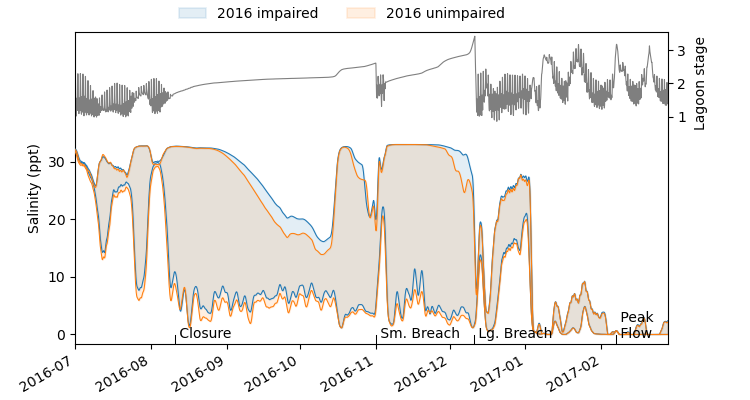

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01>


<IPython.core.display.Javascript object>


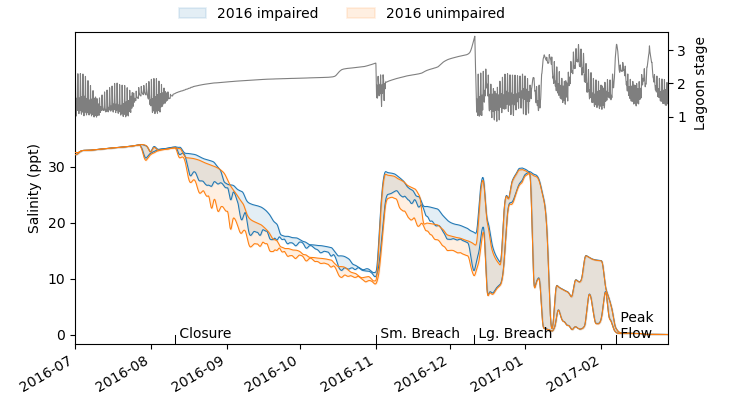

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01>


<IPython.core.display.Javascript object>


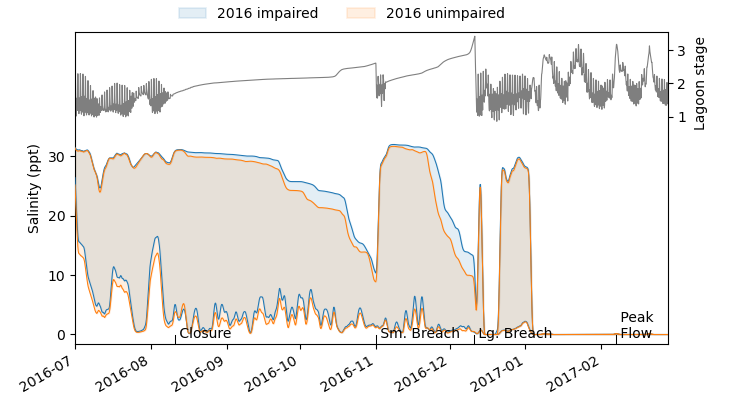

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01>


<IPython.core.display.Javascript object>


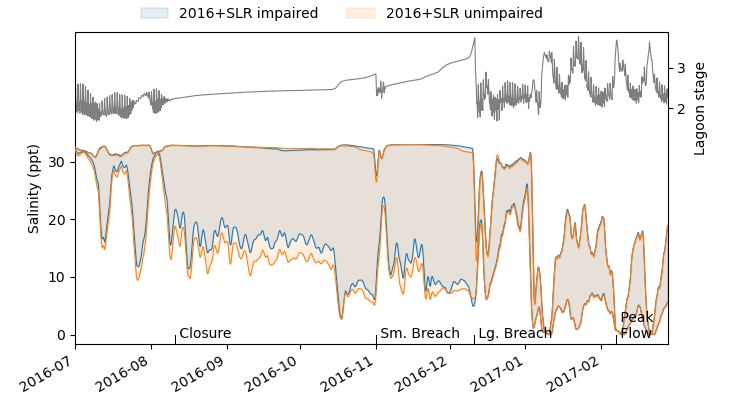

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01>


<IPython.core.display.Javascript object>


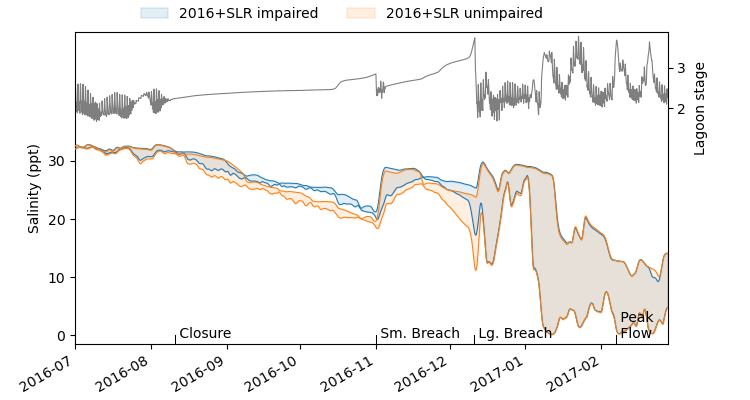

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01>


<IPython.core.display.Javascript object>


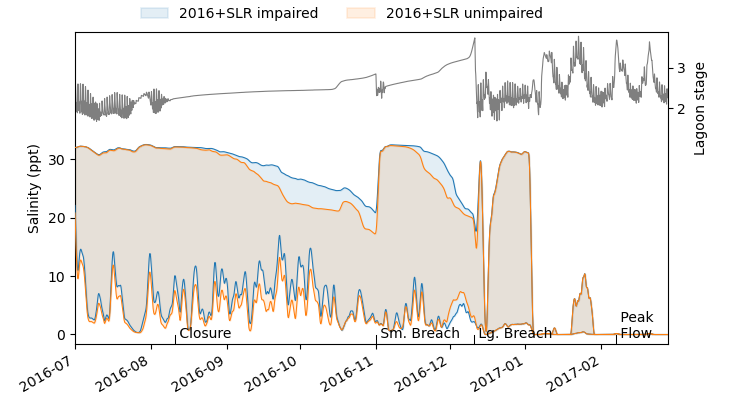

Loading stage from for twin_stage from  <DFlowModel: data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01>


<IPython.core.display.Javascript object>


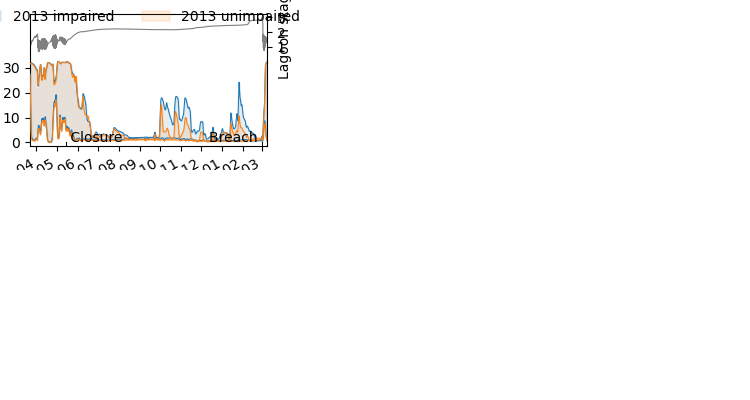

Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_l100-v000>


<IPython.core.display.Javascript object>


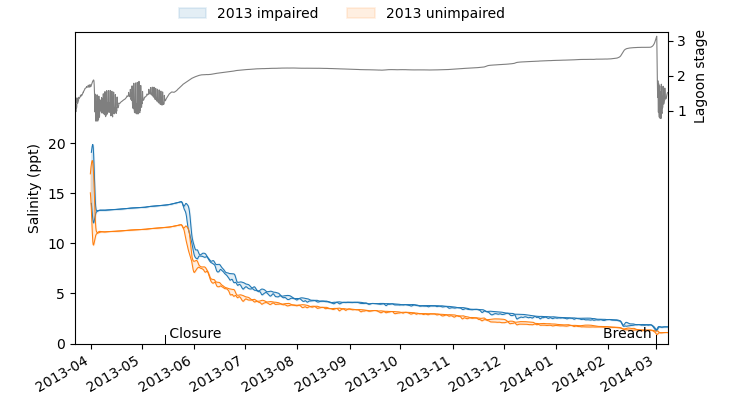

Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_l100-v000>


<IPython.core.display.Javascript object>


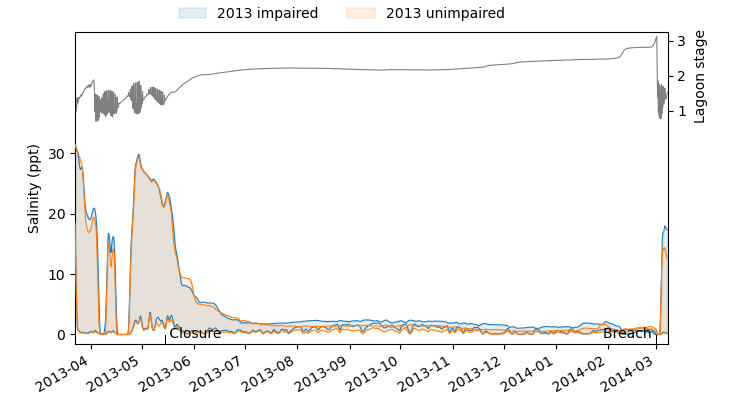

Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_l100-v000>


<IPython.core.display.Javascript object>


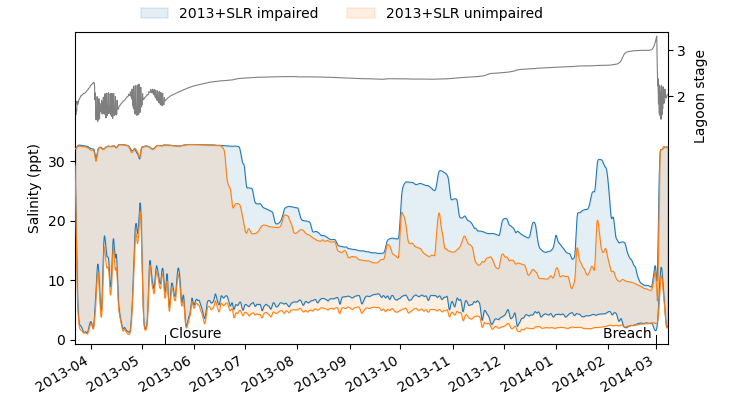

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss
2 chained datasets
Geometries match?
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_bedlevel.nc cache miss
Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l100-v000_r00>


<IPython.core.display.Javascript object>


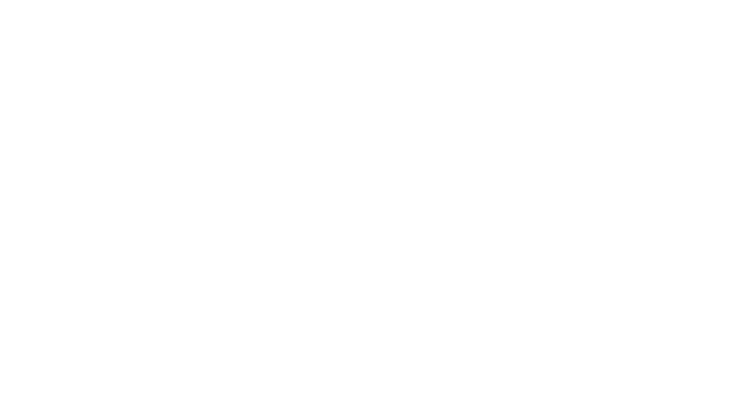

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_bedlevel.nc cache miss
Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l100-v000_r00>


<IPython.core.display.Javascript object>


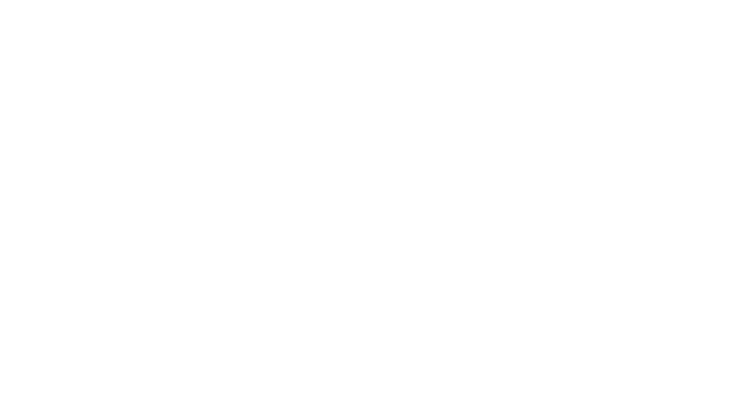

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_pc3-var_salinity.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_pc3-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_pc3-var_bedlevel.nc cache miss
Loading stage from for twin_stage from  <DFlowModel: data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l100-v000_r00>


In [13]:
# Most interested in salinity-related effects, contrasting impaired and 
# unimpaired.
salt_stations=[ ['thalweg_pesc_0000','Ocean'],
                ['nck','Lagoon'],
                ['npc','Ped. Bridge'],
                ['nmp','North Marsh Panne'],
                ['pc3','PC3'],
                ['bc1','BC1'],
                ['BC3','BC3'],
                ['ch2','CH2']
               ]

for runs, coll_name in zip(comparisons, compare_names):
    for station,label in salt_stations:
        if station not in ['nck','nmp','pc3']: continue # TMP
        fig=common.fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.025)
        fig.savefig(os.path.join(fig_dir,f'flows-salinity-timeseries-{coll_name}-stn_{station}.png'),
                    dpi=150)    
        ax1=common.twin_stage(fig,runs,scen_styles=None) # None => don't show scenario labels
        fig.savefig(os.path.join(fig_dir,f'flows-salinity-timeseries-{coll_name}-stn_{station}-with_stage.png'),
                    dpi=150)


2016 impaired
2016 unimpaired


<IPython.core.display.Javascript object>


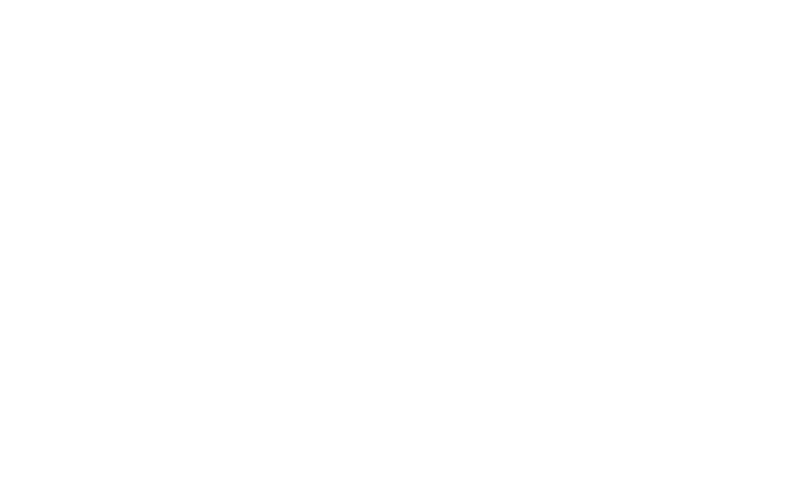

<IPython.core.display.Javascript object>


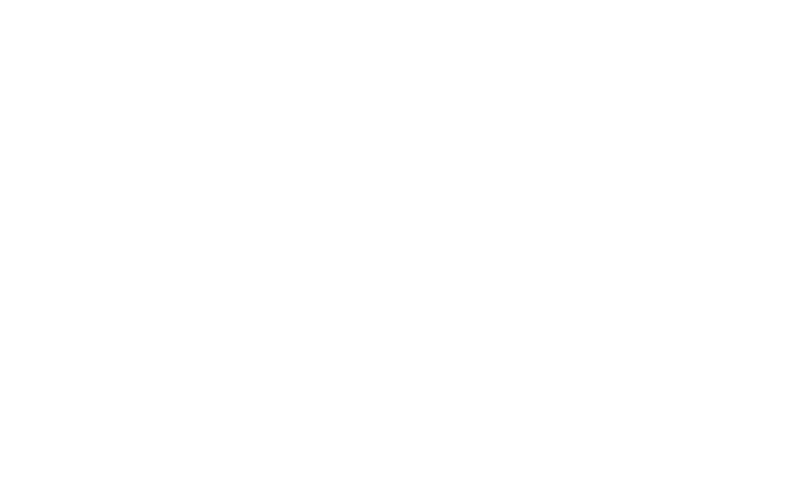

<IPython.core.display.Javascript object>


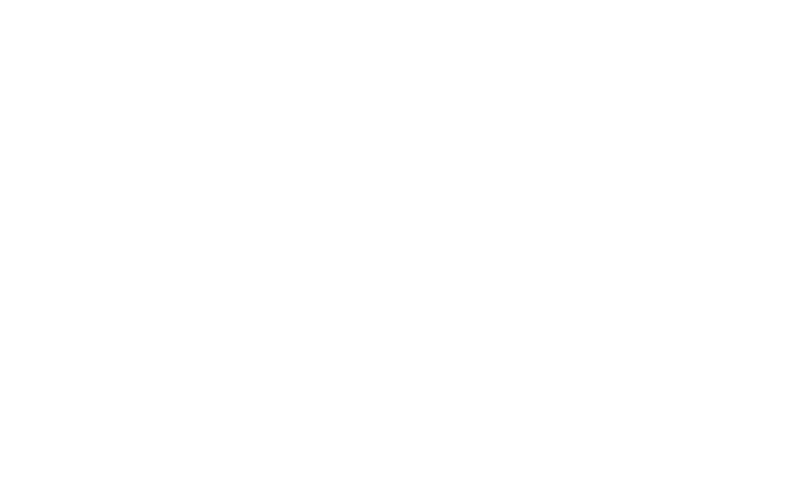

2016+SLR impaired
2016+SLR unimpaired


<IPython.core.display.Javascript object>


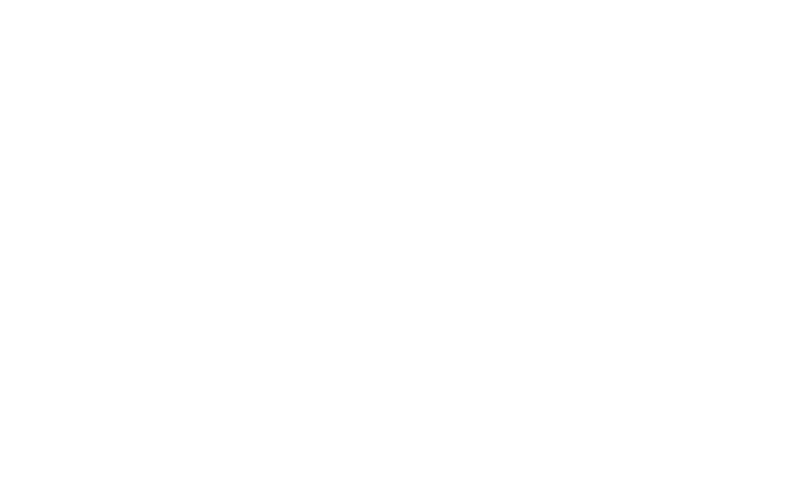

<IPython.core.display.Javascript object>


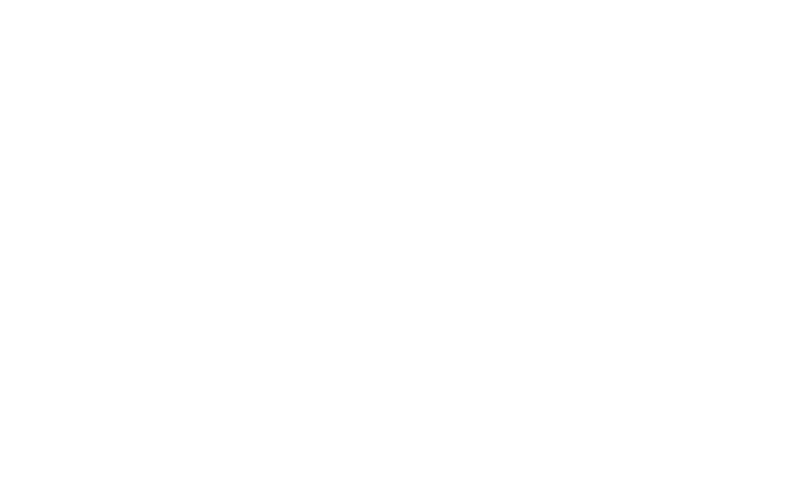

<IPython.core.display.Javascript object>


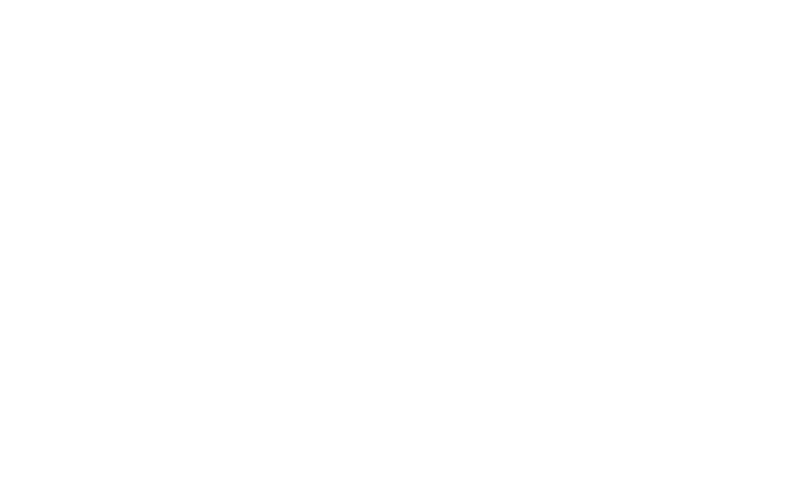

2013 impaired
2013 unimpaired


<IPython.core.display.Javascript object>


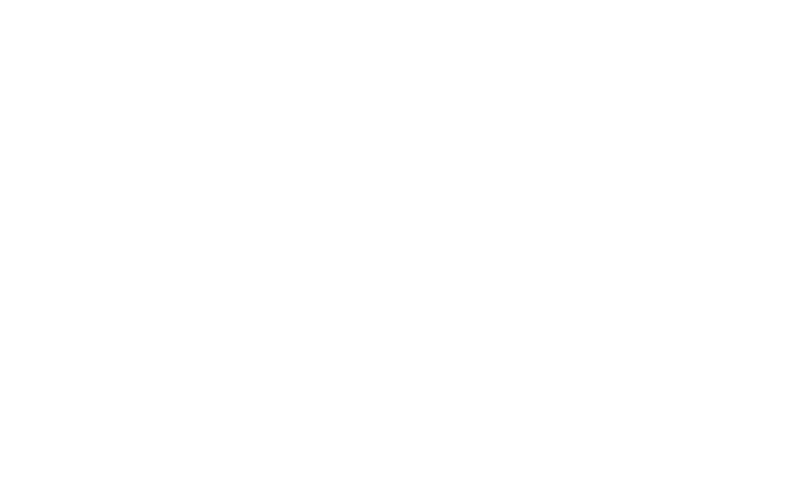

<IPython.core.display.Javascript object>


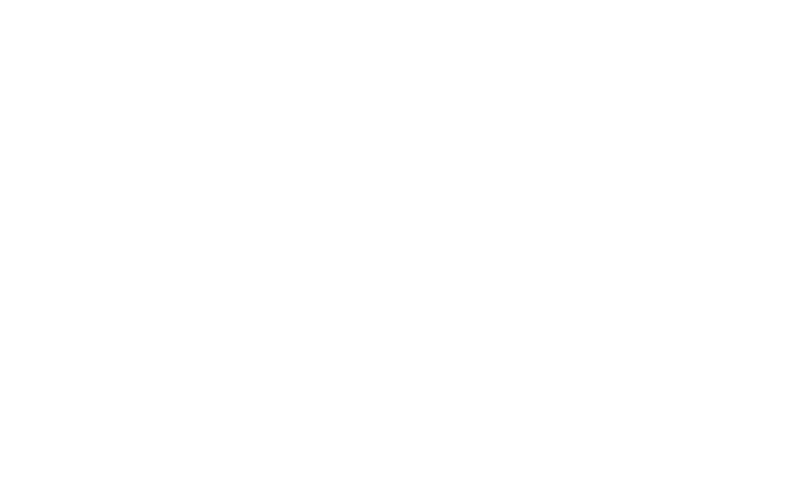

<IPython.core.display.Javascript object>


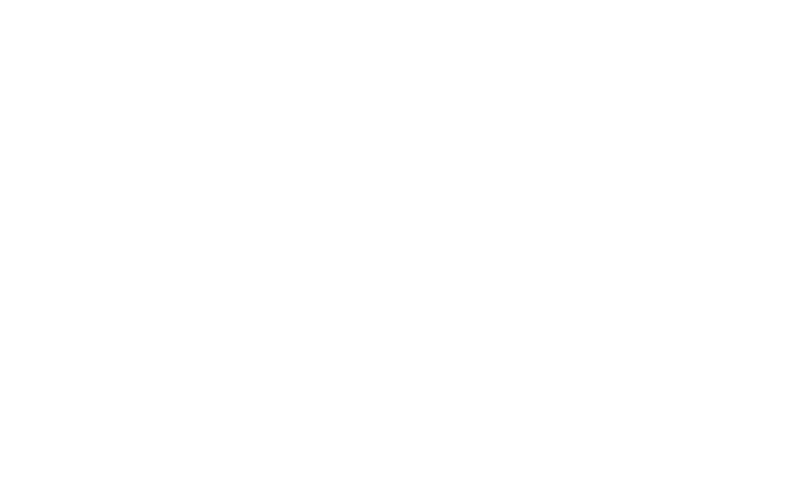

2013+SLR impaired
2013+SLR unimpaired


<IPython.core.display.Javascript object>


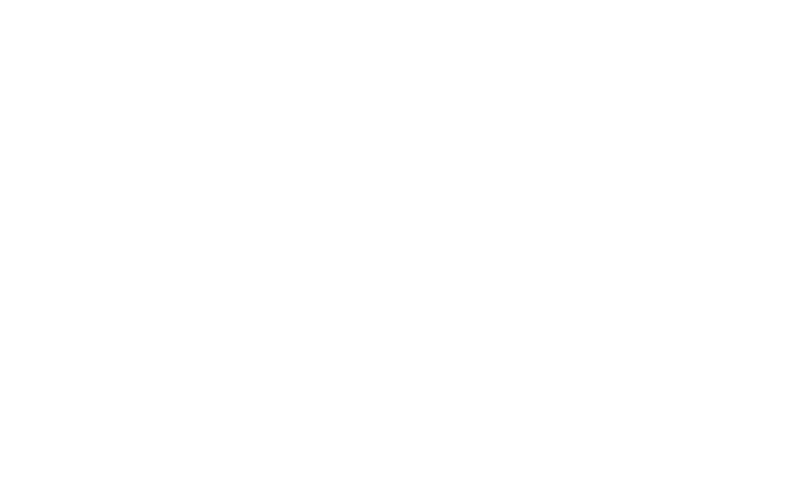

<IPython.core.display.Javascript object>


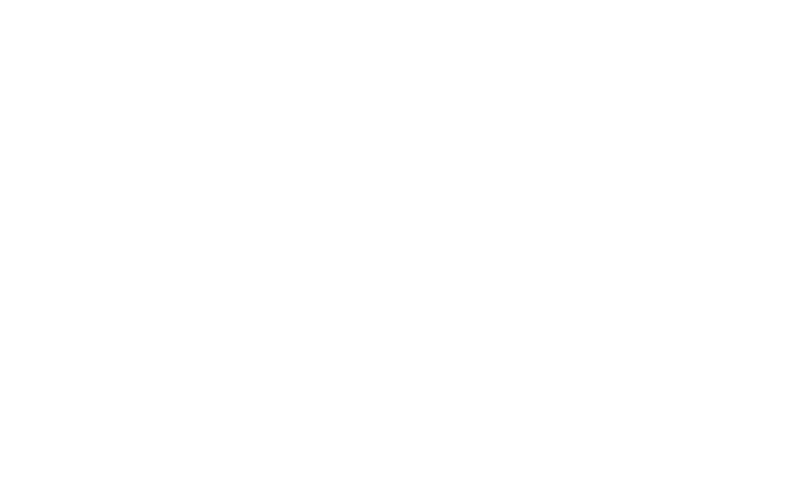

<IPython.core.display.Javascript object>


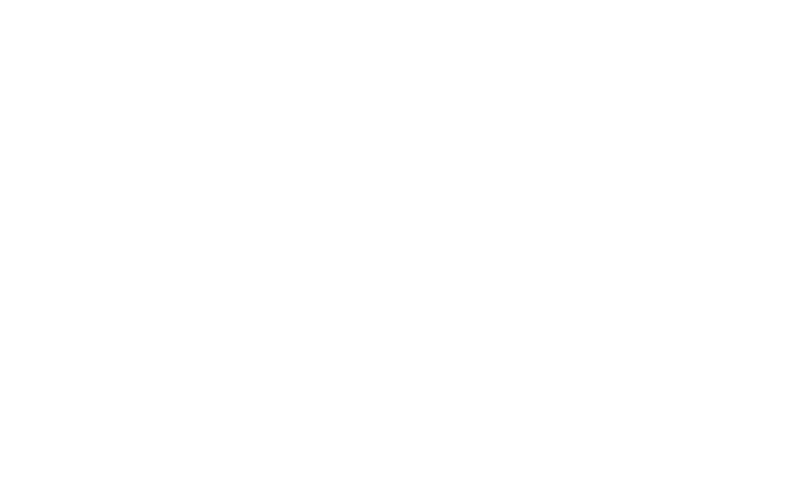

In [15]:
# Habitat: time series of area in NM that is wet and <5, <10 ppt depth-max salinity
six.moves.reload_module(common)
from common import (fresh_wet_area, fig_habitat, 
                    fig_habitat_by_region, fig_habitat_by_region_relative)

# Get the polygons for marsh and pond
region_names=['marsh','pond','lagoon']

for runs,coll_name in zip(comparisons,compare_names):
    results=[]
    for _,rec in runs.iterrows():
        print(rec['name'])
        result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
        if 'thresholds' in result:
            result['threshold']=result['thresholds']
        result['name']=(),rec['name']
        results.append(result)

    full_results=xr.concat(results,dim='name')

    # group by region
    for region in region_names:
        per_region=full_results.sel(region=region) 
        fig=fig_habitat_by_region_relative(per_region)
        fig.subplots_adjust(right=0.74) # longer run names
        img_fn=os.path.join(fig_dir,f"flows-habitat_relative-region_{region}-{coll_name}.png")
        fig.savefig(img_fn, dpi=200)

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


<IPython.core.display.Javascript object>


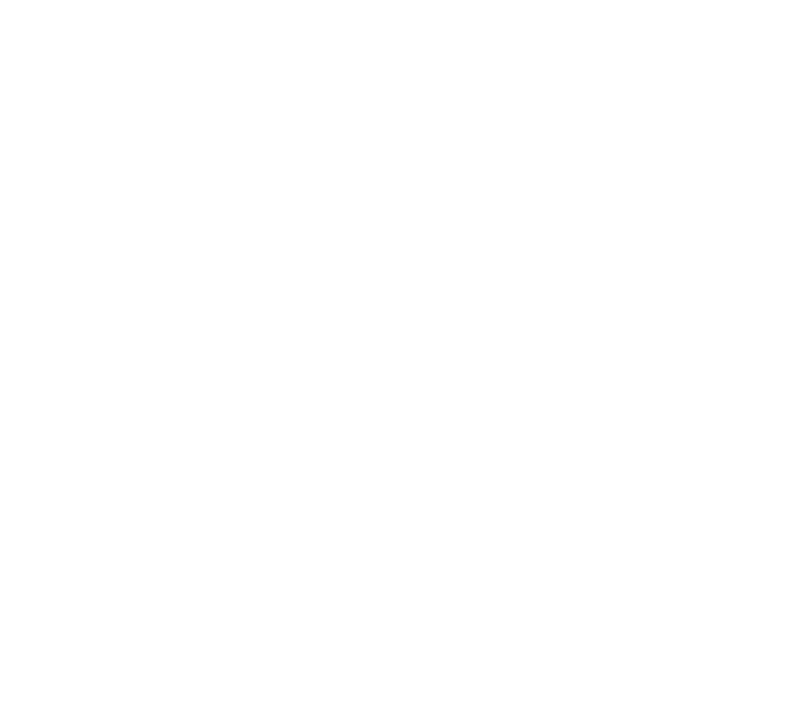

Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


<IPython.core.display.Javascript object>


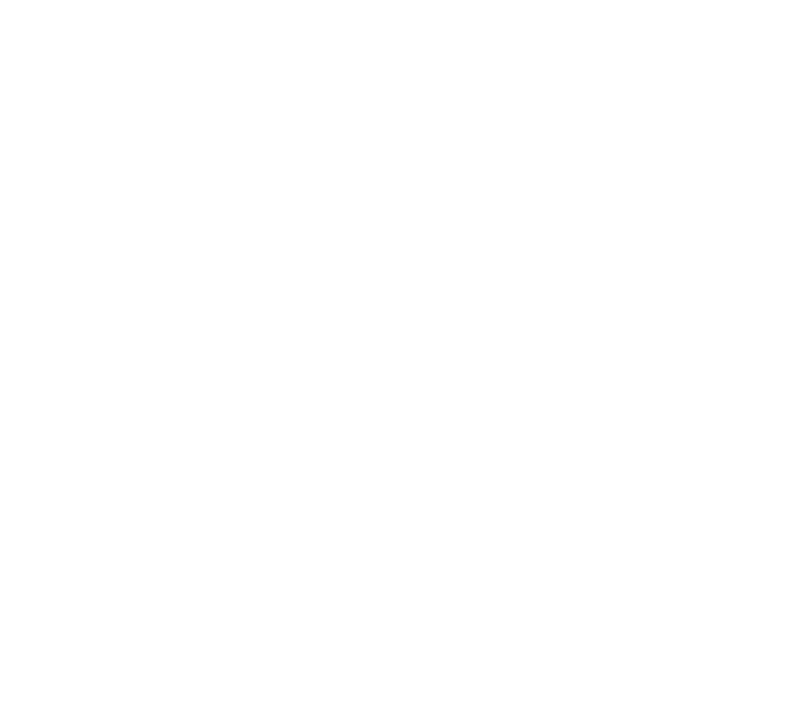

In [16]:
# Forcing figure for 2013 runs
six.moves.reload_module(common)
Qlims=[0.01,80]
fig=common.forcing_figure(['pesca_ck_imp_unimp','lagoon_wse','source_sink'],
                          period=[np.datetime64("2013-03-22"),
                                  np.datetime64("2014-03-08")],
                         Qlims=Qlims)
fig.savefig(os.path.join(fig_dir,"flows-forcing-timeseries-2013-src_sink.png"),dpi=200)

fig=common.forcing_figure(['pesca_ck_imp_unimp','lagoon_wse','source_sink'],Qlims=Qlims)
fig.savefig(os.path.join(fig_dir,"flows-forcing-timeseries-2016-src_sink.png"),dpi=200)




In [17]:
plt.close('all')

<IPython.core.display.Javascript object>


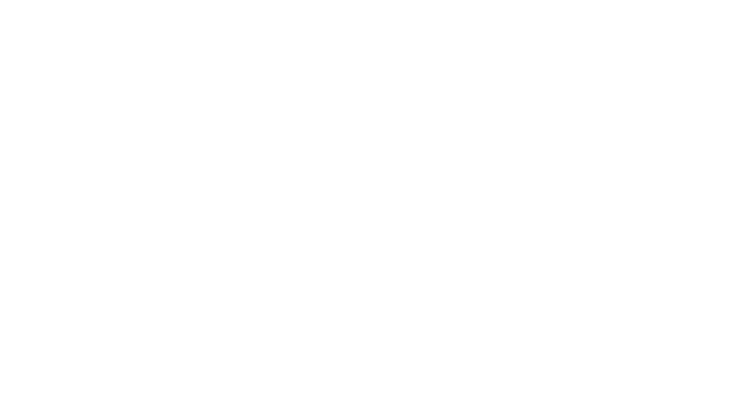

<IPython.core.display.Javascript object>


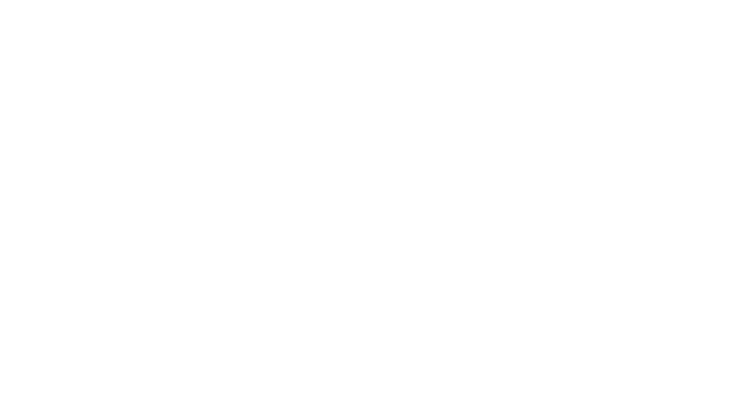

<IPython.core.display.Javascript object>


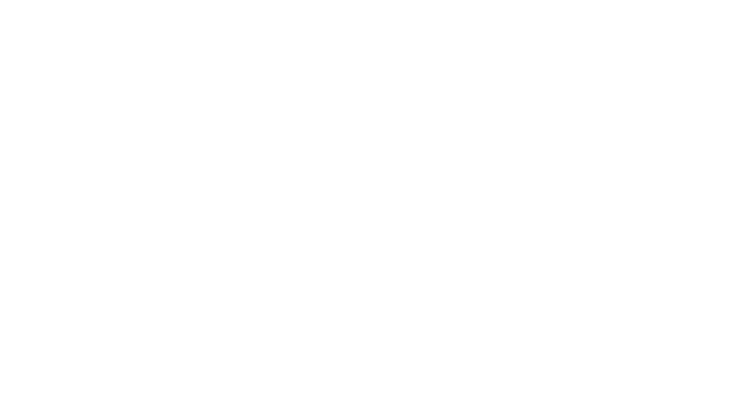

<IPython.core.display.Javascript object>


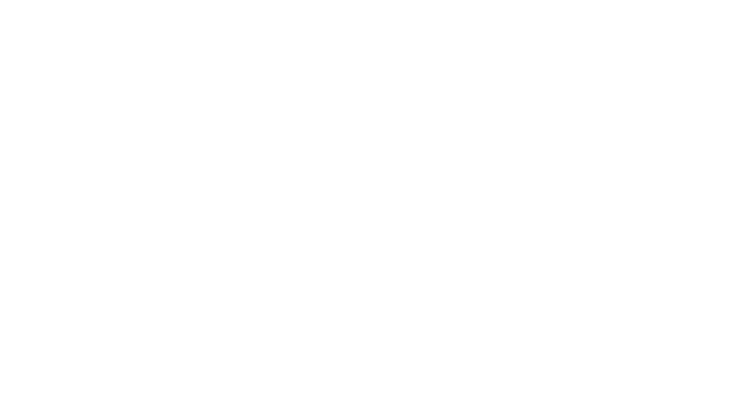

<IPython.core.display.Javascript object>


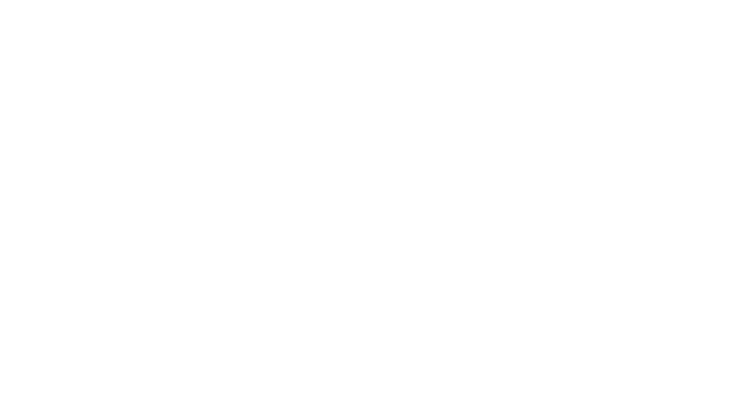

<IPython.core.display.Javascript object>


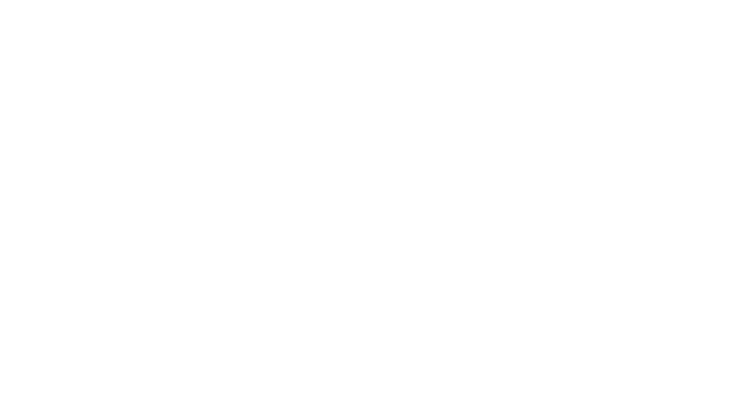

<IPython.core.display.Javascript object>


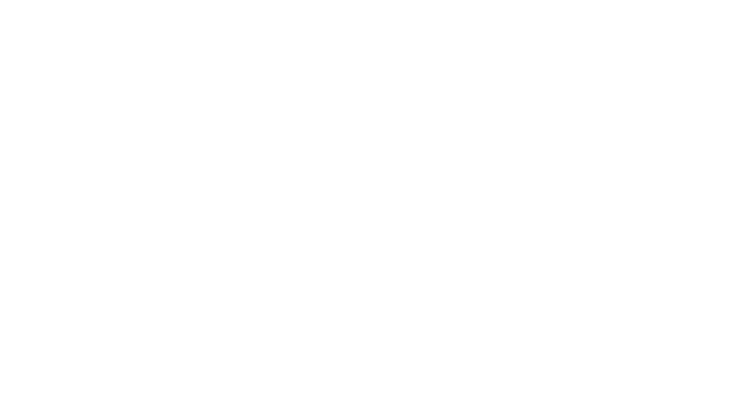

<IPython.core.display.Javascript object>


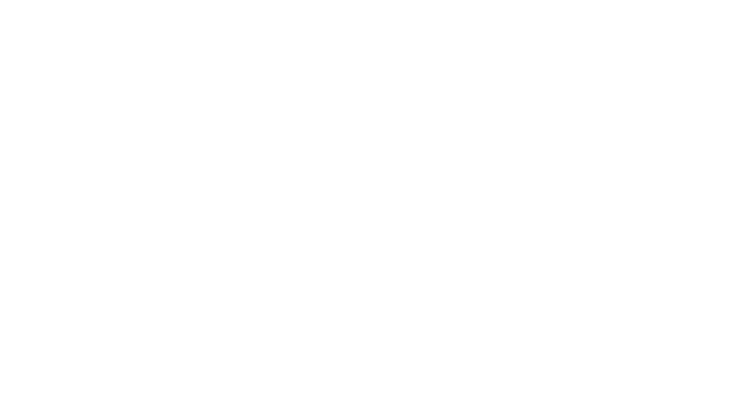

<IPython.core.display.Javascript object>


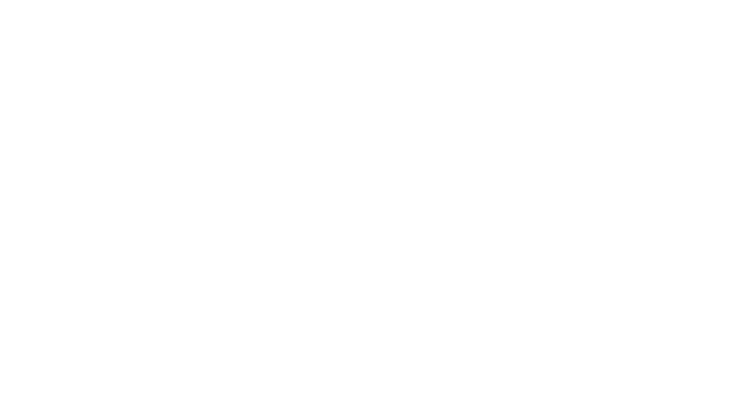

<IPython.core.display.Javascript object>


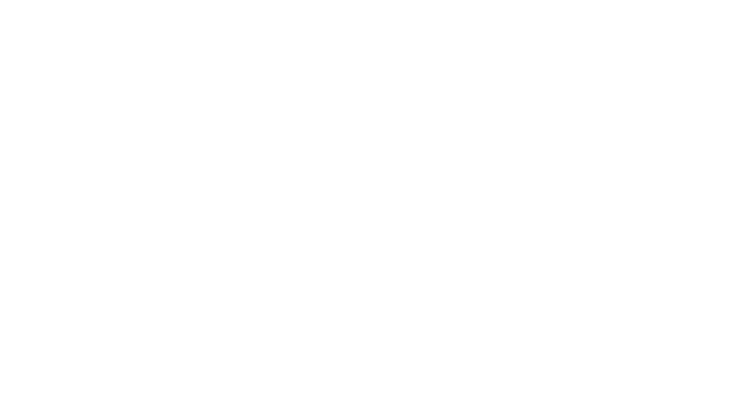

<IPython.core.display.Javascript object>


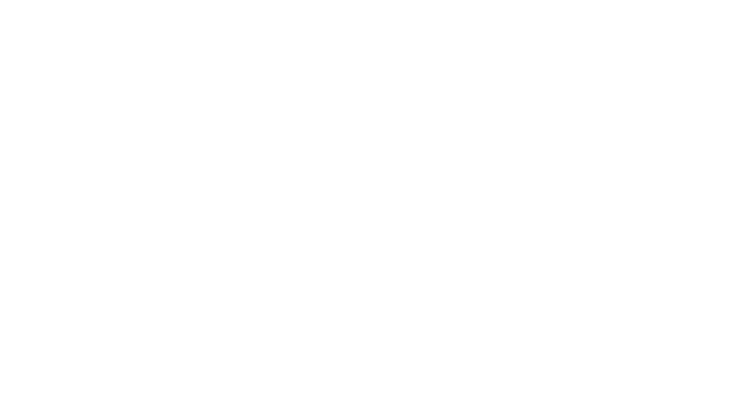

<IPython.core.display.Javascript object>


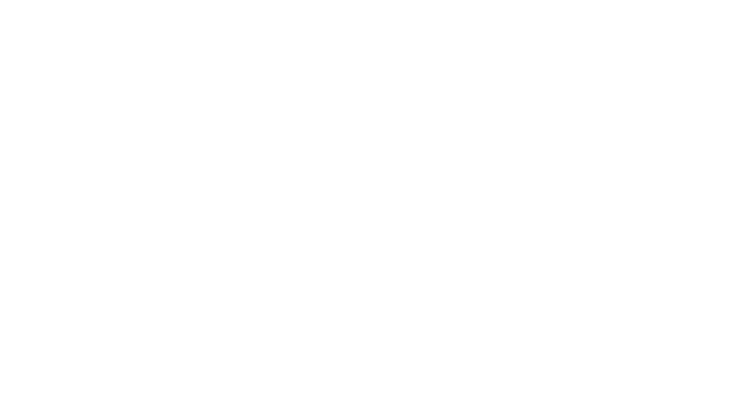

<IPython.core.display.Javascript object>


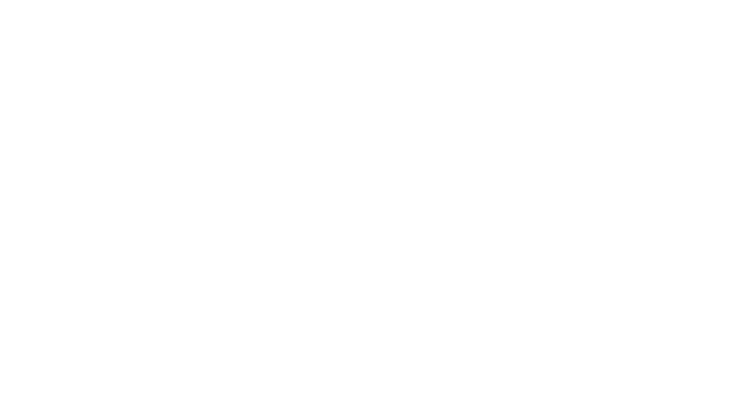

<IPython.core.display.Javascript object>


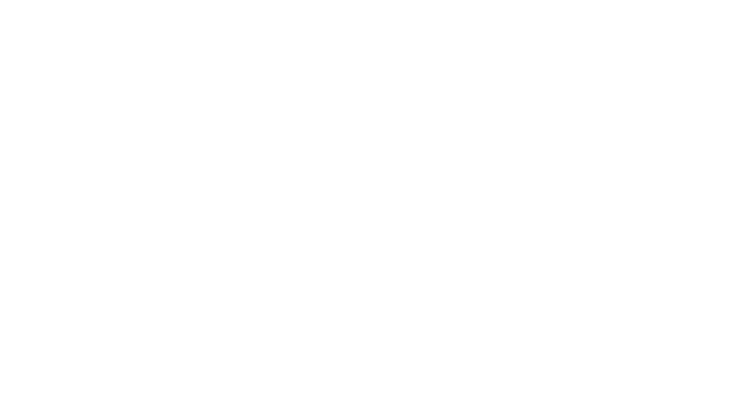

<IPython.core.display.Javascript object>


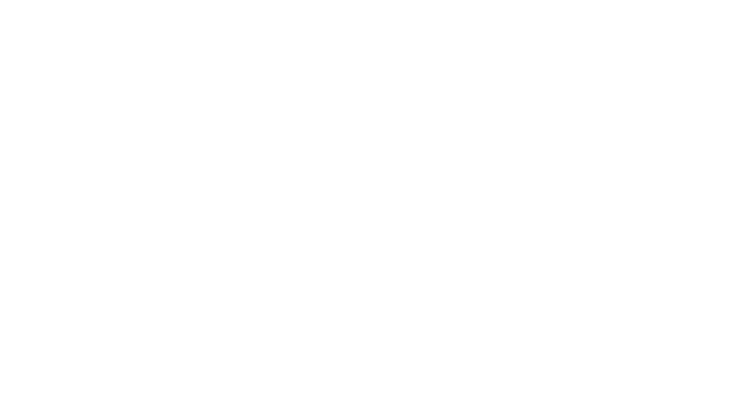

<IPython.core.display.Javascript object>


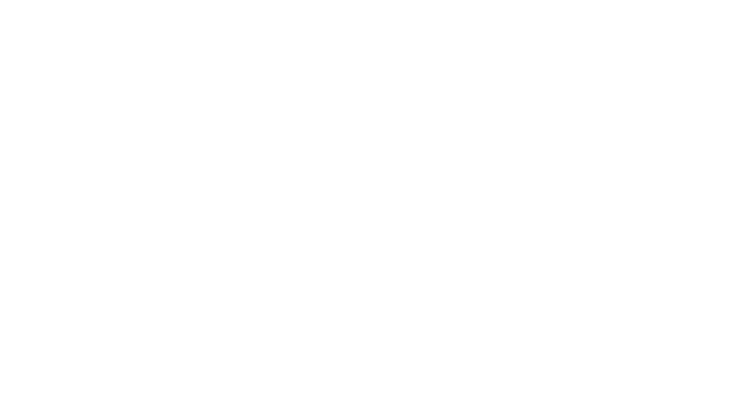

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


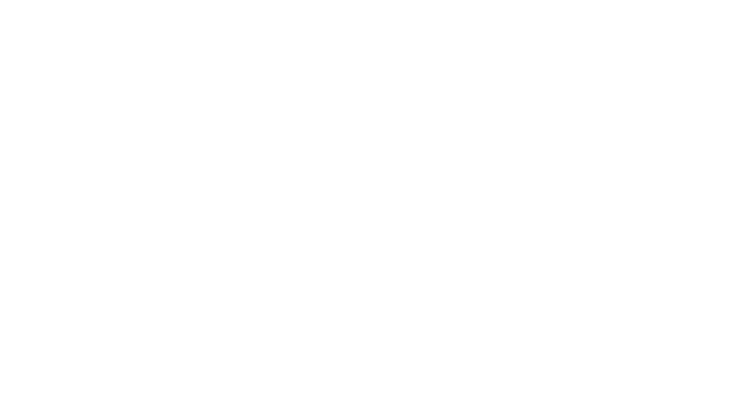

<IPython.core.display.Javascript object>


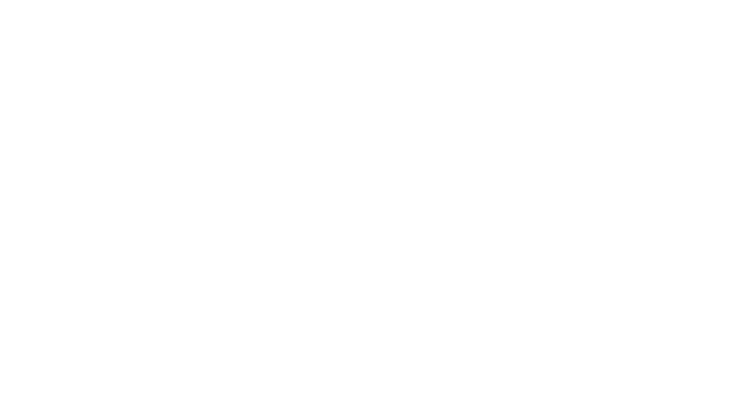

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


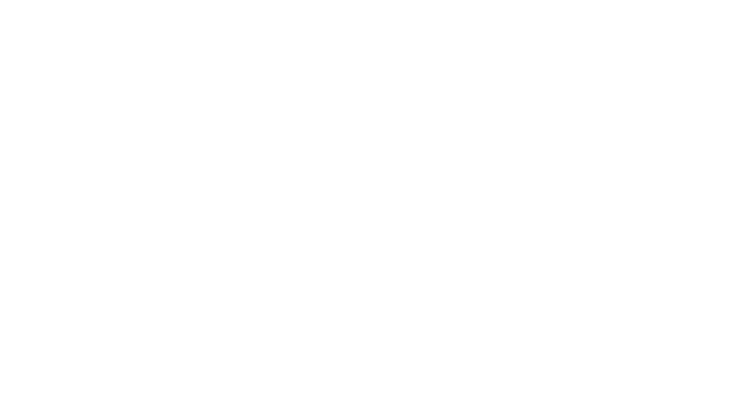

data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_waterlevel.nc cache miss
data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


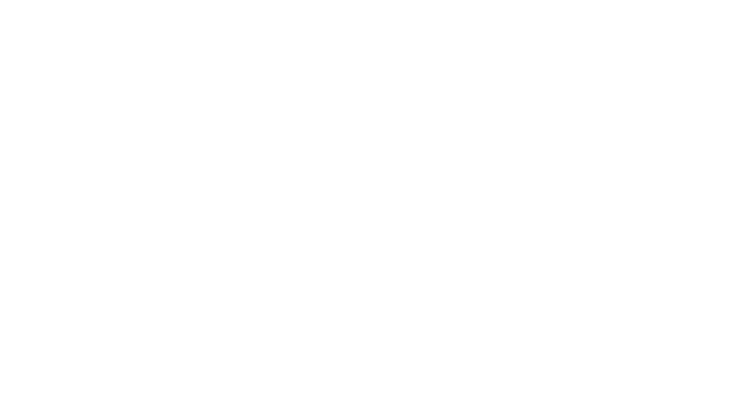

In [18]:
six.moves.reload_module(common)
from common import fig_waterlevel_bystation_timeseries

for runs,coll_name in zip(comparisons,compare_names):
    for station,label in stage_stations:
        #if station!='nck': continue # TMP
        fig=fig_waterlevel_bystation_timeseries(runs,station,label,min_depth=0.025)
        fig.savefig(os.path.join(fig_dir,f'flow-stage-timeseries-{coll_name}-stn_{station}.png'),
                    dpi=150)

In [19]:
plt.close('all')

In [20]:
import local_config
df=pd.read_csv(os.path.join(local_config.model_dir,"../forcing/tu_flows/TU_flows_SI.csv"),
               parse_dates=['time'])
df_cols=df.groupby(['flow_desc','time']).first().unstack(0).droplevel(0,axis=1).reset_index()

In [21]:
# Trying to better understand the difference between 2013 and 2016...
import pesca_base
pbm=pesca_base.PescaButanoMixin()
qcm_ds=pbm.prep_qcm_data()

Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


In [22]:
qcm_ds

<xarray.Dataset>
Dimensions:         (time: 105193)
Coordinates:
  * time            (time) datetime64[ns] 2006-01-01T08:00:00 ... 2018-01-01T08:00:00
Data variables:
    z_ocean         (time) float64 1.258 1.217 1.121 0.98 ... 1.45 1.41 1.247
    z_thalweg       (time) float64 0.6 0.6 0.6 0.6 ... 3.006 3.006 3.006 3.006
    w_inlet         (time) float64 0.0 25.93 25.93 25.93 ... 0.0 0.0 0.0 0.0
    seepage_abs     (time) float64 -0.0 0.01466 0.01521 ... 0.01944 0.02194
    evapotr_mmhour  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wave_overtop    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    z_lagoon        (time) float64 1.1 1.43 1.355 1.264 ... 2.64 2.641 2.641
    flow_inlet      (time) float64 0.0 -34.6 -32.61 -30.69 ... 0.0 0.0 0.0 0.0

In [23]:
def sel2013(t):
    return (t>=np.datetime64("2013-03-22"))&(t<np.datetime64("2014-03-08"))
def sel2016(t):
    return (t>=np.datetime64("2016-07-01"))&(t<np.datetime64("2017-02-28"))
                                        
qcm_2013=qcm_ds.sel(time=sel2013(qcm_ds.time))
qcm_2016=qcm_ds.sel(time=sel2016(qcm_ds.time))

tu_df=pd.read_csv(os.path.join(local_config.model_dir,
                            "../forcing/tu_flows/TU_flows_SI.csv"),
               parse_dates=['time'])
tu_grped=tu_df.groupby(['flow_desc','time'])['flow_cms'].first()
tu_pesc=tu_grped['Impaired flow Pe TIDAL'].reset_index()
tu_2013=tu_pesc[sel2013(tu_pesc.time)]
tu_2016=tu_pesc[sel2016(tu_pesc.time)]

<IPython.core.display.Javascript object>


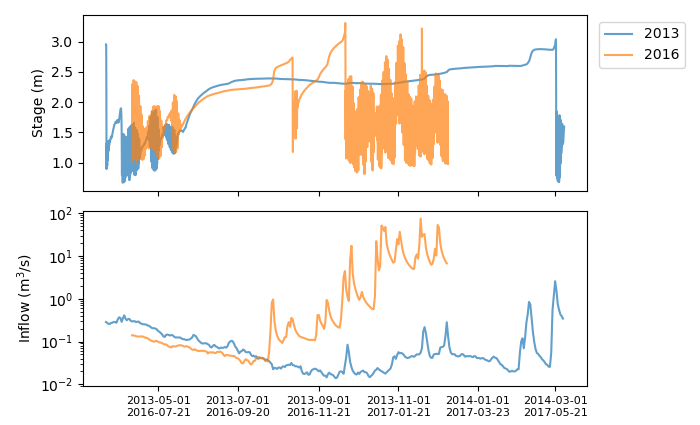

In [24]:
fig,(ax,axQ)=plt.subplots(2,1,sharex=True,figsize=(7,4.25))

field='z_lagoon'
ax.plot(qcm_2013.time, qcm_2013[field], label='2013', alpha=0.7)
days_off=3*365+82
t_off=np.timedelta64(days_off,'D')
ax.plot(qcm_2016.time-t_off, qcm_2016[field], label='2016',alpha=0.7)
ax.legend(loc='upper left',bbox_to_anchor=(1.01,1))


field='flow_cms'
axQ.plot(tu_2013.time, tu_2013[field], label='2013', alpha=0.7)
axQ.plot(tu_2016.time-t_off, tu_2016[field], label='2016',alpha=0.7)
#axQ.legend(loc='lower left')

ax.set_ylabel('Stage (m)')
axQ.set_ylabel('Inflow (m$^3$/s)')

axQ.set_yscale('log')
fig.tight_layout()

from matplotlib.dates import num2date

ticks=axQ.get_xticks()

lbls=[ (num2date(t).strftime('%Y-%m-%d')+"\n"+
       num2date(t+days_off).strftime('%Y-%m-%d'))
     for t in ticks]
axQ.set_xticks(ticks)
axQ.set_xticklabels(lbls,fontsize=8) ;
fig.savefig(os.path.join(fig_dir,'flows-2013-2016-compare.png'),dpi=150)

What's going on with the SLR run?
==

Flow went unstable in Butano Marsh. Overwriting roughness in the vicinity at the
restart was enough to tame it, and the run has completed.

In [19]:

model=flow_2013slr_runs['model'][flow_2013slr_runs.flows=='unimpaired' ].values[0]
model

<DFlowModel: data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00>

In [20]:
map_ds=model.map_dataset(chain=False)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


In [21]:
map_ds


MultiFile Layer on top of <xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 8970, mesh2d_nFaces: 5560, mesh2d_nInterfaces: 101, mesh2d_nLayers: 100, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3411, time: 17)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.531e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.123e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.532e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.123e+06
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
  * time                         (time) datetime64[ns] 2014-02-05T12:00:00 ... 2014-03-08
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
 

MultiFile Layer on top of <xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 8970, mesh2d_nFaces: 5560, mesh2d_nInterfaces: 101, mesh2d_nLayers: 100, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3411, time: 17)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.531e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.123e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.532e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.123e+06
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
  * time                         (time) datetime64[ns] 2014-02-05T12:00:00 ... 2014-03-08
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
 

<IPython.core.display.Javascript object>


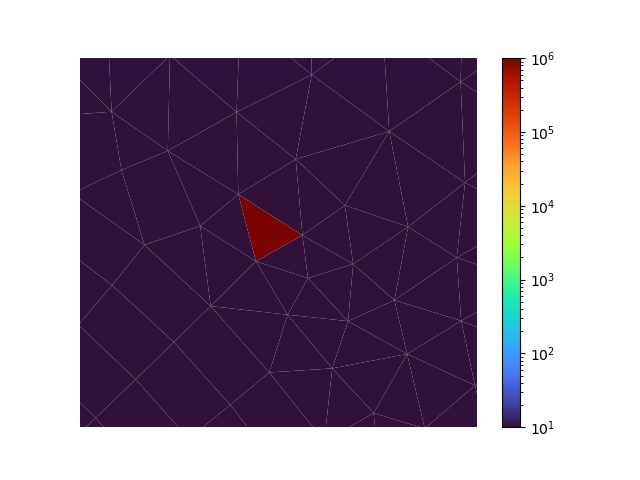

(552745.0277357599, 552806.5127902151, 4123463.4917507465, 4123514.5441798326)

In [41]:
zoom=(552745.0277357599, 552806.5127902151, 4123463.4917507465, 4123514.5441798326)
from stompy.grid import unstructured_grid

fig,ax=plt.subplots()
ax.axis('off')
ax.set_adjustable('datalim')

proc=1
if proc is not None:
    grid=unstructured_grid.UnstructuredGrid.read_ugrid(map_ds.dss[proc])
    ds=map_ds.dss[proc]
else:
    grid=map_ds.grid
    ds=map_ds

recent_limiter=ds['mesh2d_Numlimdt'].isel(time=-6).values - ds['mesh2d_Numlimdt'].isel(time=-7).values
coll=grid.plot_cells( values=recent_limiter.clip(10), cmap='turbo',norm=colors.LogNorm())

plt.colorbar(coll)
ax.axis(zoom)
# It's in this neighborhood. Salinity is not crazy.
# Velocity is nuts though.

In [48]:
ax.axis()

(552764.3947551642, 552793.8397081909, 4123475.1342433156, 4123502.560792304)

In [47]:
df=pd.read_csv("data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000/roughness-orig.xyz",
              names=['x','y','n'],sep=' ')
df.head()

x             y      n
0  552619.395697  4.123439e+06  0.055
1  552622.719241  4.123435e+06  0.055
2  552626.055405  4.123431e+06  0.055
3  552629.106483  4.123428e+06  0.055
4  552631.814277  4.123425e+06  0.055

In [51]:
sel=(df.x>=552764.39)&(df.x<=552793.839)&(df.y>=4123475.134)&(df.y<=4123502.56)
df.loc[sel,'n'] = 0.1

In [53]:
df.to_csv("data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000/roughness.xyz",
sep=' ',header=False,index=False)        

<IPython.core.display.Javascript object>


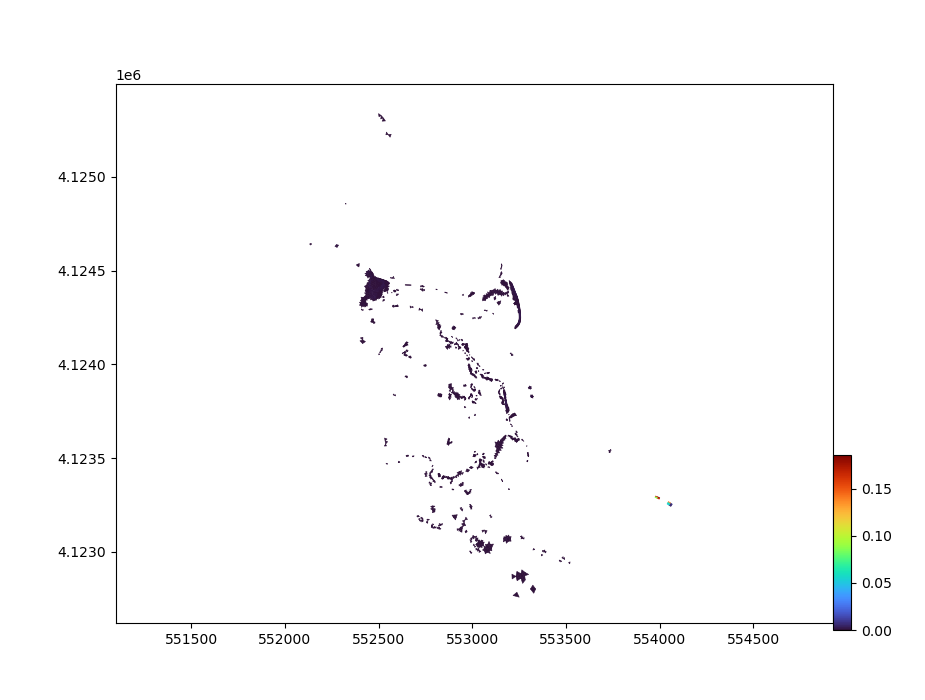

Checking for edge vars
edge dimension: mesh2d_nEdges


NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane


In [30]:
from stompy.plot import nbviz
six.moves.reload_module(nbviz)
nbviz.NBViz([map_ds])

In [28]:
# instability creeps in between 
# '2014-02-07T12:00:00' and '2014-02-09T12:00:00'
# Candidate for restart is then just the start of the run.
model.run_dir

'data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000_r00'

In [39]:
# Is there any restart data that could be modified to get things more stable?
# proc 1 is the culprit. Not clear that anything in the restart file is that
# useful for preventing the crash.
# cranking up roughness is one option.
rst=xr.open_dataset("data_2013_3d_asbuilt_unimpaired_scen0_slr0.61m_l100-v000"
                    "/DFM_OUTPUT_flowfm/flowfm_0001_20140205_120000_rst.nc")


In [40]:
rst

<xarray.Dataset>
Dimensions:           (laydim: 100, nFlowElem: 5159, nFlowLink: 8021, nFlowLinkPts: 2, nNetElem: 5159, nNetElemMaxNode: 4, nNetLink: 8250, nNetLinkPts: 2, time: 1, wdim: 101)
Coordinates:
  * time              (time) datetime64[ns] 2014-02-05T12:00:00
    FlowLink_xu       (nFlowLink) float64 ...
    FlowLink_yu       (nFlowLink) float64 ...
Dimensions without coordinates: laydim, nFlowElem, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkPts, wdim
Data variables:
    timestep          (time) timedelta64[ns] ...
    s1                (time, nFlowElem) float64 ...
    s0                (time, nFlowElem) float64 ...
    taus              (time, nFlowElem) float64 ...
    czs               (time, nFlowElem) float64 ...
    FlowElem_bl       (time, nFlowElem) float64 ...
    unorm             (time, nFlowLink, laydim) float64 ...
    u0                (time, nFlowLink, laydim) float64 ...
    q1                (time, nFlowLink, laydim) float64 ...
   